<a href="https://colab.research.google.com/github/AnkithMall/Token-Level-Explanation-Fusion-in-QA-A-Deep-Spectral-Perspective-/blob/main/Token_Level_Explanation_Fusion_in_QA_A_Deep_Spectral_Perspective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install datasets
#!pip uninstall -y numpy scikit-learn datasets transformers huggingface_hub fsspec
!pip install --upgrade datasets #fsspec huggingface_hub
#!pip install opencv-python
#!pip install scikit-learn

import torch
import numpy as np
from sklearn.metrics import auc
from transformers import BertTokenizer, BertForQuestionAnswering
import matplotlib.pyplot as plt
import re
from datasets import load_dataset

In [ ]:

# Load pretrained model and tokenizer with eager attention implementation
model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name, output_hidden_states=True, output_attentions=True, attn_implementation="eager")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), ep

In [ ]:
# Load SQuAD Dataset
squad = load_dataset("squad")
data = squad["validation"]
pert_steps = torch.tensor([0.0, 0.25, 0.50, 0.75, 1.0], device=device)

In [ ]:
# Accumulators for different score combinations
score_types = {
    'dsm': torch.zeros((len(pert_steps), len(data)), device=device),
    'modified_dsm': torch.zeros((len(pert_steps), len(data)), device=device),
    'attn': torch.zeros((len(pert_steps), len(data)), device=device),
    'grad': torch.zeros((len(pert_steps), len(data)), device=device),
    'dsm_attn_grad': torch.zeros((len(pert_steps), len(data)), device=device),
    'dsm_attn': torch.zeros((len(pert_steps), len(data)), device=device),
    'attn_grad': torch.zeros((len(pert_steps), len(data)), device=device),
    'dsm_grad': torch.zeros((len(pert_steps), len(data)), device=device),
    'decompx': torch.zeros((len(pert_steps), len(data)), device=device),
    'dsm_attn_grad_decompx': torch.zeros((len(pert_steps), len(data)), device=device),
    'hila_chefer': torch.zeros((len(pert_steps), len(data)), device=device),
    'dsm_hila_chefer': torch.zeros((len(pert_steps), len(data)), device=device),
    'dsm_hila_chefer_grad_attn': torch.zeros((len(pert_steps), len(data)), device=device),
    'dsm_hila_chefer_grad_attn_decompx': torch.zeros((len(pert_steps), len(data)), device=device),
    'modified_dsm_attn_grad_hidden': torch.zeros((len(pert_steps), len(data)), device=device),
    'modified_dsm_attn': torch.zeros((len(pert_steps), len(data)), device=device),
    'modified_dsm_grad': torch.zeros((len(pert_steps), len(data)), device=device),
    'modified_dsm_attn_weighted': torch.zeros((len(pert_steps), len(data)), device=device),
    'qg_dsa': torch.zeros((len(pert_steps), len(data)), device=device),
    'ultra': torch.zeros((len(pert_steps), len(data)), device=device),

}

pert_scores_pos = {key: score.clone() for key, score in score_types.items()}
pert_scores_neg = {key: score.clone() for key, score in score_types.items()}

In [ ]:
# Helper functions
def clean_text(text):
    return re.sub(r"[^\w\s]", "", text).strip()

def get_answer_and_confidence(model, tokenizer, inputs):
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    answer_start = outputs.start_logits.argmax()
    answer_end = outputs.end_logits.argmax() + 1
    answer = tokenizer.decode(inputs["input_ids"][0][answer_start:answer_end].cpu())
    start_probs = torch.softmax(outputs.start_logits, dim=-1)
    end_probs = torch.softmax(outputs.end_logits, dim=-1)
    confidence = start_probs.max() + end_probs.max()
    return answer, confidence, outputs


def compute_attention_scores(attentions, use_all_layers=False):
    if use_all_layers:
        attn = torch.stack(attentions).mean(dim=0)
        attn = attn.mean(dim=1).squeeze(0)
    else:
        attn = attentions[-1].mean(dim=1).squeeze(0)
    return attn.sum(dim=1) / attn.sum()

def compute_gradient_scores(inputs, model):
    inputs = {k: v.to(device) for k, v in inputs.items()}
    input_ids = inputs["input_ids"]
    embeddings = model.bert.embeddings(input_ids)
    embeddings.retain_grad()
    outputs = model(inputs_embeds=embeddings, attention_mask=inputs["attention_mask"],
                    token_type_ids=inputs["token_type_ids"])
    loss = (outputs.start_logits + outputs.end_logits).sum()
    loss.backward()
    grad = embeddings.grad.abs().sum(dim=-1).squeeze(0)
    return grad / torch.max(grad)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def generate_heatmap(scores, tokens, method_name, output_dir="heatmaps_output"):
    """
    Generates and saves a heatmap for a given set of token attribution scores.

    Args:
        scores (torch.Tensor): A 1D tensor of attribution scores, including special tokens like [CLS] and [SEP].
        tokens (list): A list of token strings, which excludes the special tokens.
        method_name (str): The name of the attribution method, used for the plot title and filename.
        output_dir (str): The directory where the heatmap image will be saved.
    """
    # Ensure the output directory exists; create it if it doesn't.
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # --- Data Preparation ---
    # 1. Select the scores that correspond to the actual tokens (excluding [CLS] and [SEP]).
    # 2. Move the score tensor from the GPU/CPU to a CPU-based NumPy array for plotting.
    scores_to_plot = scores[1:-1].cpu().numpy()

    # As a safeguard, ensure the number of tokens matches the number of scores.
    min_len = min(len(scores_to_plot), len(tokens))
    scores_to_plot = scores_to_plot[:min_len]
    tokens = tokens[:min_len]

    # Reshape scores to be a 2D array (1 row) as required by the heatmap function.
    scores_2d = np.array([scores_to_plot])

    # --- Plotting ---
    # Create a new, independent figure for each heatmap. Adjust figsize as needed.
    fig, ax = plt.subplots(figsize=(max(18, len(tokens) * 0.5), 4))

    # Generate the heatmap using seaborn.
    sns.heatmap(
        scores_2d,
        annot=False,
        cmap="coolwarm",  # Diverging colormap is good for values centered at zero.
        cbar=True,
        xticklabels=tokens,
        yticklabels=False,  # Hide y-axis labels as they are not needed for a single row.
        ax=ax,
        center=0          # Center the color bar on zero.
    )

    # --- Customization and Saving ---
    # Customize plot labels and title.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=10)
    ax.set_title(f"Token Attribution Heatmap: {method_name}", fontsize=16, fontweight='bold', pad=20)

    # Create a clean, valid filename from the method name.
    clean_method_name = method_name.replace('+', '_').replace(' ', '_')
    filename = f"heatmap_{clean_method_name}.png"
    filepath = os.path.join(output_dir, filename)

    # Save the figure to the specified file path.
    plt.savefig(filepath, bbox_inches='tight')

    # Close the figure to free up memory and prevent it from displaying in the output console.
    plt.close(fig)


In [ ]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

import os
os.chdir(f'./Transformer-Explainability')

#!pip install -r requirements.txt
#!pip install captum
#from BERT_explainability.modules.relevance_propagation import LRP
from BERT_explainability.modules.BERT.ExplanationGenerator import Generator


Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 386 (delta 3), reused 2 (delta 2), pack-reused 381 (from 2)
Receiving objects: 100% (386/386), 3.85 MiB | 6.11 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [ ]:
from BERT_explainability.modules.BERT.ExplanationGenerator import Generator

In [ ]:
#!grep -rnw './BERT_explainability/modules/BERT/' -e 'class LRP'

#from BERT_explainability.modules.BERT.relevance_propagation import LRP
# Create models directory
#!mkdir -p models

# Save custom_bert_qa.py
#%%writefile models/custom_model.py
import torch
import torch.nn as nn
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel

class CustomBertForQuestionAnswering(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config, add_pooling_layer=False)
        self.qa_outputs = nn.Linear(config.hidden_size, 2)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        start_positions=None,
        end_positions=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = outputs[0]
        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1).contiguous()
        end_logits = end_logits.squeeze(-1).contiguous()

        total_loss = None
        if start_positions is not None and end_positions is not None:
            loss_fct = nn.CrossEntropyLoss()
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2

        if not return_dict:
            output = (start_logits, end_logits) + outputs[2:]
            return ((total_loss,) + output) if total_loss is not None else output

        return {
            "start_logits": start_logits,
            "end_logits": end_logits,
            "loss": total_loss,
            "hidden_states": outputs.hidden_states,
            "attentions": outputs.attentions,
        }

    def relprop(self, cam=None, **kwargs):
        """
        Perform Layer-wise Relevance Propagation (LRP) for QA.

        Args:
            cam: Relevance scores to propagate (default: None).
            **kwargs: Additional arguments, including 'index' for start/end position.

        Returns:
            Relevance scores for input tokens.
        """
        index = kwargs.get("index")
        outputs = self.forward(
            input_ids=kwargs.get("input_ids"),
            attention_mask=kwargs.get("attention_mask"),
            token_type_ids=kwargs.get("token_type_ids"),
            output_attentions=True,
            output_hidden_states=True,
        )
        start_logits = outputs["start_logits"]
        end_logits = outputs["end_logits"]

        # Initialize relevance
        if cam is None:
            if index is not None:
                cam_start = torch.zeros_like(start_logits)
                cam_end = torch.zeros_like(end_logits)
                cam_start[:, index] = start_logits[:, index]
                cam_end[:, index] = end_logits[:, index]
                cam = torch.cat([cam_start.unsqueeze(-1), cam_end.unsqueeze(-1)], dim=-1)
            else:
                cam = torch.cat([start_logits.unsqueeze(-1), end_logits.unsqueeze(-1)], dim=-1)

        # Propagate through qa_outputs
        qa_outputs_weight = self.qa_outputs.weight
        qa_outputs_bias = self.qa_outputs.bias
        sequence_output = outputs["hidden_states"][-1]
        z = torch.matmul(sequence_output, qa_outputs_weight.t()) + qa_outputs_bias
        z = z + 1e-10
        s = cam / z
        c = torch.matmul(s, qa_outputs_weight)
        cam = sequence_output * c

        # Propagate through BERT
        cam = self.bert.relprop(cam, **kwargs)

        return cam

In [ ]:
def compute_dsm_scores(hidden_states, use_all_layers=False):
    if use_all_layers:
        hs = torch.stack(hidden_states).mean(dim=0).squeeze(0)
    else:
        hs = hidden_states[-1].squeeze(0)
    hs = torch.nn.functional.normalize(hs, p=2, dim=1)
    similarity_matrix = torch.matmul(hs, hs.T)
    degree_matrix = torch.diag(similarity_matrix.sum(dim=1))
    laplacian_matrix = degree_matrix - similarity_matrix
    eigenvalues, eigenvectors = torch.linalg.eigh(laplacian_matrix)
    eigenvector = eigenvectors[:, 1] * (-1)
    return eigenvector / torch.max(torch.abs(eigenvector))

def compute_modified_dsm_scores(inputs, outputs, model, use_all_layers=False, alpha=0.5):
    """
    Compute modified DSM scores using a combination of input embedding gradients and attention scores.
    """
    attentions = outputs.attentions  # (num_layers, batch, heads, seq_len, seq_len)

    # Compute attention scores
    if use_all_layers:
        attn_scores = torch.stack(attentions).mean(dim=0)  # (batch, heads, seq_len, seq_len)
        attn_scores = attn_scores.mean(dim=1).squeeze(0)    # (seq_len, seq_len)
    else:
        attn_scores = attentions[-1].mean(dim=1).squeeze(0) # (seq_len, seq_len)
    attn_scores = attn_scores.sum(dim=1) / (attn_scores.sum() + 1e-10)  # (seq_len)

    # Compute input embedding gradients
    model.zero_grad()
    inputs_clone = {k: v.clone() for k, v in inputs.items()}
    input_ids = inputs_clone["input_ids"]
    embeddings = model.bert.embeddings(input_ids)
    embeddings.retain_grad()
    outputs = model(inputs_embeds=embeddings, attention_mask=inputs_clone["attention_mask"],
                    token_type_ids=inputs_clone["token_type_ids"], output_attentions=True)
    loss = (outputs.start_logits + outputs.end_logits).sum()
    loss.backward()
    grad = embeddings.grad.abs().sum(dim=-1).squeeze(0)  # (seq_len)
    grad = grad / (grad.sum() + 1e-10)  # Normalize

    # Combine gradients and attention scores
    combined = alpha * grad + (1 - alpha) * attn_scores  # (seq_len)
    combined = torch.nn.functional.normalize(combined.unsqueeze(-1), p=2, dim=0)  # (seq_len, 1)

    # Compute similarity matrix
    similarity_matrix = torch.matmul(combined, combined.T)  # (seq_len, seq_len)

    # Compute Laplacian
    degree_matrix = torch.diag(similarity_matrix.sum(dim=1))
    laplacian_matrix = degree_matrix - similarity_matrix

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eigh(laplacian_matrix)
    eigenvector = eigenvectors[:, 1] * (-1)  # Second smallest eigenvector

    return eigenvector / torch.max(torch.abs(eigenvector) + 1e-10)

def modified_dsm_attn_grad_hidden(inputs, outputs, model, use_all_layers=False, alpha=0.33, beta=0.33):
    """
    Compute modified DSM scores using a combination of hidden states, input embedding gradients, and attention scores.
    """
    attentions = outputs.attentions  # (num_layers, batch, heads, seq_len, seq_len)
    hidden_states = outputs.hidden_states  # (num_layers, batch, seq_len, hidden_size)

    # Compute attention scores
    if use_all_layers:
        attn_scores = torch.stack(attentions).mean(dim=0)  # (batch, heads, seq_len, seq_len)
        attn_scores = attn_scores.mean(dim=1).squeeze(0)    # (seq_len, seq_len)
    else:
        attn_scores = attentions[-1].mean(dim=1).squeeze(0) # (seq_len, seq_len)
    attn_scores = attn_scores.sum(dim=1) / (attn_scores.sum() + 1e-10)  # (seq_len)

    # Compute input embedding gradients
    model.zero_grad()
    inputs_clone = {k: v.clone() for k, v in inputs.items()}
    input_ids = inputs_clone["input_ids"]
    embeddings = model.bert.embeddings(input_ids)
    embeddings.retain_grad()
    outputs = model(inputs_embeds=embeddings, attention_mask=inputs_clone["attention_mask"],
                    token_type_ids=inputs_clone["token_type_ids"], output_hidden_states=True)
    loss = (outputs.start_logits + outputs.end_logits).sum()
    loss.backward()
    grad = embeddings.grad.abs().sum(dim=-1).squeeze(0)  # (seq_len)
    grad = grad / (grad.sum() + 1e-10)  # Normalize

    # Compute hidden state scores
    if use_all_layers:
        hs = torch.stack(hidden_states).mean(dim=0).squeeze(0)  # (seq_len, hidden_size)
    else:
        hs = hidden_states[-1].squeeze(0)  # (seq_len, hidden_size)
    hs_norm = torch.norm(hs, p=2, dim=-1)  # (seq_len)
    hs_scores = hs_norm / (hs_norm.sum() + 1e-10)  # Normalize

    # Combine hidden states, gradients, and attention scores
    combined = alpha * grad + beta * attn_scores + (1 - alpha - beta) * hs_scores  # (seq_len)
    combined = torch.nn.functional.normalize(combined.unsqueeze(-1), p=2, dim=0)  # (seq_len, 1)

    # Compute similarity matrix
    similarity_matrix = torch.matmul(combined, combined.T)  # (seq_len, seq_len)

    # Compute Laplacian
    degree_matrix = torch.diag(similarity_matrix.sum(dim=1))
    laplacian_matrix = degree_matrix - similarity_matrix

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eigh(laplacian_matrix)
    eigenvector = eigenvectors[:, 1] * (-1)  # Second smallest eigenvector

    return eigenvector / torch.max(torch.abs(eigenvector) + 1e-10)

def modified_dsm_attn(inputs, outputs, model, use_all_layers=False):
    """
    Compute modified DSM scores using attention scores directly as the similarity matrix.
    """
    attentions = outputs.attentions  # (num_layers, batch, heads, seq_len, seq_len)

    # Compute attention-based similarity matrix
    if use_all_layers:
        similarity_matrix = torch.stack(attentions).mean(dim=0)  # (batch, heads, seq_len, seq_len)
        similarity_matrix = similarity_matrix.mean(dim=1).squeeze(0)  # (seq_len, seq_len)
    else:
        similarity_matrix = attentions[-1].mean(dim=1).squeeze(0)  # (seq_len, seq_len)

    # Ensure symmetry and non-negativity
    similarity_matrix = (similarity_matrix + similarity_matrix.T) / 2  # Make symmetric
    similarity_matrix = torch.clamp(similarity_matrix, min=0)  # Ensure non-negative

    # Compute Laplacian
    degree_matrix = torch.diag(similarity_matrix.sum(dim=1))
    laplacian_matrix = degree_matrix - similarity_matrix

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eigh(laplacian_matrix)
    eigenvector = eigenvectors[:, 1] * (-1)  # Second smallest eigenvector

    return eigenvector / torch.max(torch.abs(eigenvector) + 1e-10)

def modified_dsm_grad(inputs, outputs, model, use_all_layers=False):
    model.zero_grad()
    inputs_clone = {k: v.clone() for k, v in inputs.items()}
    input_ids = inputs_clone["input_ids"]
    embeddings = model.bert.embeddings(input_ids)
    embeddings.retain_grad()
    outputs = model(inputs_embeds=embeddings, attention_mask=inputs_clone["attention_mask"],
                    token_type_ids=inputs_clone["token_type_ids"])
    loss = (outputs.start_logits + outputs.end_logits).sum()
    loss.backward()
    grad = embeddings.grad.abs().sum(dim=-1).squeeze(0)
    grad = grad / (grad.sum() + 1e-10)
    combined = torch.nn.functional.normalize(grad.unsqueeze(-1), p=2, dim=0)
    similarity_matrix = torch.matmul(combined, combined.T)
    degree_matrix = torch.diag(similarity_matrix.sum(dim=1))
    laplacian_matrix = degree_matrix - similarity_matrix
    eigenvalues, eigenvectors = torch.linalg.eigh(laplacian_matrix)
    eigenvector = eigenvectors[:, 1] * (-1)
    return eigenvector / torch.max(torch.abs(eigenvector) + 1e-10)


def modified_dsm_attn_weighted(inputs, outputs, model, use_all_layers=False):
    """
    Compute modified DSM scores using attention weighted by input embedding gradients.
    G = |∇_embed Loss|, A_weighted = A · G, score = sum_j (A · G)_ij
    """
    attentions = outputs.attentions  # (num_layers, batch, heads, seq_len, seq_len)

    # Compute attention scores
    if use_all_layers:
        attn_scores = torch.stack(attentions).mean(dim=0)  # (batch, heads, seq_len, seq_len)
        attn_scores = attn_scores.mean(dim=1).squeeze(0)    # (seq_len, seq_len)
    else:
        attn_scores = attentions[-1].mean(dim=1).squeeze(0) # (seq_len, seq_len)

    # Compute input embedding gradients
    model.zero_grad()
    inputs_clone = {k: v.clone() for k, v in inputs.items()}
    input_ids = inputs_clone["input_ids"]
    embeddings = model.bert.embeddings(input_ids)
    embeddings.retain_grad()
    outputs = model(inputs_embeds=embeddings, attention_mask=inputs_clone["attention_mask"],
                    token_type_ids=inputs_clone["token_type_ids"], output_attentions=True)
    loss = (outputs.start_logits + outputs.end_logits).sum()
    loss.backward()
    grad = embeddings.grad.abs().sum(dim=-1).squeeze(0)  # (seq_len)
    grad = grad / (grad.sum() + 1e-10)  # Normalize gradients (G)

    # Compute weighted attention: A · G
    # Since attn_scores is (seq_len, seq_len) and grad is (seq_len),
    # we broadcast grad to match dimensions
    grad_broadcast = grad.unsqueeze(1)  # (seq_len, 1)
    weighted_attn = attn_scores * grad_broadcast  # (seq_len, seq_len)

    # Sum over columns (j) to get per-token scores: sum_j (A · G)_ij
    combined_scores = weighted_attn.sum(dim=1)  # (seq_len)
    combined_scores = combined_scores / (combined_scores.sum() + 1e-10)  # Normalize

    # Compute similarity matrix using combined scores
    combined = torch.nn.functional.normalize(combined_scores.unsqueeze(-1), p=2, dim=0)  # (seq_len, 1)
    similarity_matrix = torch.matmul(combined, combined.T)  # (seq_len, seq_len)

    # Compute Laplacian
    degree_matrix = torch.diag(similarity_matrix.sum(dim=1))
    laplacian_matrix = degree_matrix - similarity_matrix

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eigh(laplacian_matrix)
    eigenvector = eigenvectors[:, 1] * (-1)  # Second smallest eigenvector

    return eigenvector / torch.max(torch.abs(eigenvector) + 1e-10)

def compute_decompx_scores(inputs, outputs, model, use_all_layers=False):
    """
    DecompX aligned with Modarressi et al. (2023), fixed einsum for attention decomposition.
    Formulas:
        x_i^l = sum_k x_{i<-k}^l (Eq. 1)
        z_i^l = sum_k sum_h sum_j alpha_{i,j}^h x_{j<-k}^l W_Att^h (Eq. 4, simplified)
        z_FFN,i^l = sum_k theta^(zeta_i^l) otimes zeta_{i<-k}^l W_FFN^2 (Eq. 11, simplified)
        y_c = sum_k y_{c<-k} (Eq. 14, adapted for QA: y_Start<-k, y_End<-k)
    Args:
        inputs: Tokenized input dictionary (input_ids, attention_mask).
        outputs: Model outputs (hidden_states, attentions, start_logits, end_logits).
        model: BertForQuestionAnswering model.
        use_all_layers: If True, propagate through all layers; if False, use last layer only.
    """
    model.eval()
    with torch.no_grad():
        batch_size, seq_len = inputs['input_ids'].shape
        hidden_size = model.config.hidden_size
        num_layers = model.config.num_hidden_layers
        num_heads = model.config.num_attention_heads

        # Ensure batch_size=1 for memory efficiency
        if batch_size != 1:
            raise ValueError(f"Expected batch_size=1, got {batch_size}. Process examples individually.")

        # Validate outputs.attentions
        if outputs.attentions[0].shape[0] != batch_size:
            raise ValueError(f"Batch size mismatch: outputs.attentions[0] has batch_size {outputs.attentions[0].shape[0]}, but inputs has {batch_size}")

        if use_all_layers:
            # Initialize decomposition
            embeddings = model.bert.get_input_embeddings()(inputs['input_ids'])  # (1, seq_len, hidden_size)
            decomposition = torch.zeros(1, seq_len, seq_len, hidden_size, device=embeddings.device)
            for i in range(seq_len):
                decomposition[0, i, i, :] = embeddings[0, i, :]

            # Propagate through layers
            for layer in range(num_layers):
                attention_layer = model.bert.encoder.layer[layer].attention
                attention_scores = outputs.attentions[layer] / num_heads  # (1, heads, seq_len, seq_len)

                # Vectorized attention decomposition
                weighted = torch.einsum('bhij,bjkm->bikm', attention_scores, decomposition)  # (1, seq_len, seq_len, hidden_size)
                new_decomposition = attention_layer.output.dense(weighted.view(-1, hidden_size)).view(1, seq_len, seq_len, hidden_size)
                decomposition = decomposition + new_decomposition
                del weighted, new_decomposition

                ffn_layer = model.bert.encoder.layer[layer].intermediate
                ffn_output = model.bert.encoder.layer[layer].output
                for k in range(seq_len):
                    input_k = decomposition[0, :, k, :]  # (seq_len, hidden_size)
                    intermediate = ffn_layer.dense(input_k)  # (seq_len, intermediate_size)
                    theta = torch.where(intermediate != 0, ffn_layer.intermediate_act_fn(intermediate) / intermediate, 1.0)
                    ffn_out = theta * intermediate
                    ffn_out = ffn_output.dense(ffn_out)  # (seq_len, hidden_size)
                    decomposition[0, :, k, :] = ffn_out
                del intermediate, theta, ffn_out

                decomposition = ffn_output.LayerNorm(decomposition)

            # QA head
            qa_weights = model.qa_outputs.weight  # (2, hidden_size)
            logits = torch.matmul(decomposition, qa_weights.transpose(-1, -2))  # (1, seq_len, seq_len, 2)
            scores_start = logits[0, :, :, 0].sum(dim=0)  # (seq_len,)
            scores_end = logits[0, :, :, 1].sum(dim=0)    # (seq_len,)
            scores = (scores_start + scores_end) / (torch.max(torch.abs(scores_start + scores_end)) + 1e-8)
            del logits, scores_start, scores_end

        else:
            # Last layer only
            hidden_states = outputs.hidden_states[-1]  # (1, seq_len, hidden_size)
            attention_scores = outputs.attentions[-1] / num_heads  # (1, heads, seq_len, seq_len)

            hidden_states = hidden_states / (torch.norm(hidden_states, p=2, dim=-1, keepdim=True) + 1e-8)
            qa_weights = model.qa_outputs.weight  # (2, hidden_size)
            features = torch.matmul(hidden_states, qa_weights.transpose(-1, -2))  # (1, seq_len, 2)
            token_contributions = torch.matmul(attention_scores, features)  # (1, seq_len, 2)

            start_logits, end_logits = outputs.start_logits, outputs.end_logits
            scores = torch.abs(token_contributions[0, :, 0] * start_logits[0] + token_contributions[0, :, 1] * end_logits[0])
            scores = scores / (torch.max(scores) + 1e-8)
            del features, token_contributions

        # Clean up
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return scores

def compute_hila_chefer_scores(inputs, outputs, model, use_all_layers=False):
    """
    Compute Hila Chefer scores using input embedding gradients and attention scores.
    """
    hidden_states = outputs.hidden_states
    attentions = outputs.attentions
    start_logits = outputs.start_logits.squeeze(0)
    end_logits = outputs.end_logits.squeeze(0)
    if use_all_layers:
        hs = torch.stack(hidden_states).mean(dim=0).squeeze(0)
        attn = torch.stack(attentions).mean(dim=0)
    else:
        hs = hidden_states[-1].squeeze(0)
        attn = attentions[-1]
    hs = torch.nn.functional.normalize(hs, p=2, dim=1)

    # Compute input embedding gradients
    model.zero_grad()
    inputs_clone = {k: v.clone() for k, v in inputs.items()}
    input_ids = inputs_clone["input_ids"]
    embeddings = model.bert.embeddings(input_ids)
    embeddings.retain_grad()
    outputs = model(inputs_embeds=embeddings, attention_mask=inputs_clone["attention_mask"],
                    token_type_ids=inputs_clone["token_type_ids"], output_attentions=True)
    loss = (outputs.start_logits + outputs.end_logits).sum()
    loss.backward()
    attn_grad = embeddings.grad.abs().sum(dim=-1).squeeze(0)  # (seq_len)
    attn_grad = attn_grad / (attn_grad.sum() + 1e-10)  # Normalize

    attn = attn.mean(dim=1).squeeze(0)
    weighted_attn = attn * attn_grad.unsqueeze(0)
    weighted_attn = weighted_attn / (weighted_attn.sum(dim=1, keepdim=True) + 1e-10)
    qa_weights = model.qa_outputs.weight.data.T
    ffn_contributions = torch.matmul(hs, qa_weights)
    relevance = torch.matmul(weighted_attn, ffn_contributions)
    relevance_scores = (relevance[:, 0] * start_logits +
                        relevance[:, 1] * end_logits)
    return relevance_scores.abs() / torch.max(relevance_scores.abs() + 1e-10)


'''
def compute_hila_chefer_scores(inputs, outputs, model, use_all_layers=False):
    """
    Compute Hila Chefer scores using Layer-wise Relevance Propagation (LRP) for QA.

    Args:
        inputs: Dictionary with input_ids, attention_mask, token_type_ids (batch_size=1).
        outputs: Model outputs (start_logits, end_logits, hidden_states, attentions).
        model: BertForQuestionAnswering model.
        use_all_layers: If True, propagate relevance through all layers; if False, start from last layer.

    Returns:
        torch.Tensor: Normalized relevance scores for tokens (seq_len).
    """
    # Initialize ExplanationGenerator
    explanations = Generator(model)

    # Ensure inputs are on the correct device
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Compute relevance for start and end logits
    start_logits = outputs.start_logits.squeeze(0)  # (seq_len)
    end_logits = outputs.end_logits.squeeze(0)    # (seq_len)
    start_target = start_logits.argmax().item()
    end_target = end_logits.argmax().item()

    # Set start_layer based on use_all_layers
    start_layer = 0 if use_all_layers else 11  # BERT has 12 layers (0-11)

    # Compute LRP relevance for start and end positions using index
    relevance_start = explanations.generate_LRP(
        input_ids=input_ids,
        attention_mask=attention_mask,
        index=start_target,
        start_layer=start_layer
    )[0]

    relevance_end = explanations.generate_LRP(
        input_ids=input_ids,
        attention_mask=attention_mask,
        index=end_target,
        start_layer=start_layer
    )[0]

    # Combine and normalize relevance scores
    relevance_scores = relevance_start + relevance_end
    relevance_scores = torch.abs(relevance_scores) / (torch.max(torch.abs(relevance_scores)) + 1e-10)

    return relevance_scores
    '''
'''
def compute_hila_chefer_scores(inputs, outputs, model, use_all_layers=False):
    """
    Compute Hila Chefer scores using Layer-wise Relevance Propagation (LRP) for QA.

    Args:
        inputs: Dictionary with input_ids, attention_mask, token_type_ids (batch_size=1).
        outputs: Model outputs (start_logits, end_logits, hidden_states, attentions).
        model: BertForQuestionAnswering model (used for compatibility; actual LRP uses CustomBertForQuestionAnswering).
        use_all_layers: If True, propagate relevance through all layers; if False, start from last layer.

    Returns:
        torch.Tensor: Normalized relevance scores for tokens (seq_len).
    """
    # Initialize custom model for LRP
    lrp_model = CustomBertForQuestionAnswering.from_pretrained(
        "bert-large-uncased-whole-word-masking-finetuned-squad",
        output_hidden_states=True,
        output_attentions=True
    ).to(model.device)
    lrp_model.eval()

    # Initialize ExplanationGenerator with the custom model
    explanations = Generator(lrp_model)

    # Ensure inputs are on the correct device
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Get start and end positions from outputs
    start_logits = outputs.start_logits.squeeze(0)  # (seq_len)
    end_logits = outputs.end_logits.squeeze(0)      # (seq_len)
    start_target = start_logits.argmax().item()
    end_target = end_logits.argmax().item()

    # Set start_layer based on use_all_layers (bert-large has 24 layers, indexed 0-23)
    start_layer = 0 if use_all_layers else 23

    # Compute LRP relevance for start position
    relevance_start = explanations.generate_LRP(
        input_ids=input_ids,
        attention_mask=attention_mask,
        index=start_target,
        start_layer=start_layer
    )

    # Compute LRP relevance for end position
    relevance_end = explanations.generate_LRP(
        input_ids=input_ids,
        attention_mask=attention_mask,
        index=end_target,
        start_layer=start_layer
    )

    # Combine and normalize relevance scores
    relevance_scores = relevance_start + relevance_end
    relevance_scores = torch.abs(relevance_scores) / (torch.max(torch.abs(relevance_scores)) + 1e-10)

    # Clean up
    del lrp_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return relevance_scores
  '''


def compute_qg_dsa_scores(hidden_states, inputs, model, tokenizer, gamma=0.5):
    """
    Compute Question-Guided Dynamic Spectral Analysis (QG-DSA) scores.

    Args:
        hidden_states: Tuple of hidden states from BERT (num_layers, batch, seq_len, hidden_size).
        inputs: Tokenized input dictionary (input_ids, attention_mask, token_type_ids).
        model: BertForQuestionAnswering model.
        tokenizer: BertTokenizer.
        gamma: Weight for combining layer-weighted and question-aligned matrices (default: 0.5).

    Returns:
        scores: Normalized token importance scores.
    """
    device = hidden_states[0].device
    qa_weights = model.qa_outputs.weight.data  # (2, hidden_size)

    # Step 1: Layer-weighted similarity matrix
    layer_weights = []
    similarity_matrices = []
    for hs in hidden_states:
        hs = hs.squeeze(0)  # (seq_len, hidden_size)
        hs_norm = torch.nn.functional.normalize(hs, p=2, dim=1)
        sim_matrix = torch.matmul(hs_norm, hs_norm.T)  # (seq_len, seq_len)
        similarity_matrices.append(sim_matrix)
        logits = torch.matmul(hs, qa_weights.T)  # (seq_len, 2)
        layer_weight = torch.norm(logits, p=2)  # Scalar
        layer_weights.append(layer_weight)

    layer_weights = torch.tensor(layer_weights, device=device)
    layer_weights = layer_weights / (layer_weights.sum() + 1e-10)
    S_layers = torch.stack(similarity_matrices).mul(layer_weights.view(-1, 1, 1)).sum(dim=0)

    # Step 2: Question-context alignment
    question_end = inputs["token_type_ids"].sum(dim=1).item()
    embeddings = model.bert.embeddings(inputs["input_ids"]).squeeze(0)  # (seq_len, hidden_size)
    question_cls = embeddings[0]  # [CLS] token
    context_emb = embeddings[question_end:-1]  # Context tokens (exclude [SEP])
    align_scores = torch.nn.functional.cosine_similarity(question_cls, context_emb, dim=-1)
    align_scores = align_scores / (align_scores.sum() + 1e-10)
    # Pad align_scores to match seq_len
    align_scores_full = torch.zeros(inputs["input_ids"].size(1), device=device)
    align_scores_full[question_end:-1] = align_scores
    S_align = torch.matmul(align_scores_full.unsqueeze(-1), align_scores_full.unsqueeze(-1).T)

    # Step 3: Combine and spectral analysis
    S_qgdsa = gamma * S_layers + (1 - gamma) * S_align
    D = torch.diag(S_qgdsa.sum(dim=1))
    L = D - S_qgdsa
    eigenvalues, eigenvectors = torch.linalg.eigh(L)
    scores = eigenvectors[:, 1] * (-1)  # Second smallest eigenvector
    scores = scores / (torch.max(torch.abs(scores)) + 1e-10)

    return scores

import networkx as nx
def compute_ultra_scores(inputs, outputs, model, use_all_layers=False, alpha=0.4, beta=0.4):
    """
    Compute ULTra scores for token importance using attention, gradients, and hidden states with PageRank.

    Args:
        inputs: Dictionary with input_ids, attention_mask, token_type_ids (batch_size=1).
        outputs: Model outputs (hidden_states, attentions, start_logits, end_logits).
        model: BertForQuestionAnswering model.
        use_all_layers: If True, average across all layers; if False, use last layer only.
        alpha: Weight for attention scores in graph construction (default: 0.4).
        beta: Weight for gradient scores in graph construction (default: 0.4).

    Returns:
        torch.Tensor: Normalized ULTra scores for tokens (seq_len).
    """
    device = inputs['input_ids'].device
    seq_len = inputs['input_ids'].size(1)

    # Step 1: Compute attention scores
    attentions = outputs.attentions  # (num_layers, batch, heads, seq_len, seq_len)
    if use_all_layers:
        attn_scores = torch.stack(attentions).mean(dim=0).squeeze(0)  # (heads, seq_len, seq_len)
        attn_scores = attn_scores.mean(dim=0)  # (seq_len, seq_len)
    else:
        attn_scores = attentions[-1].squeeze(0).mean(dim=0)  # (seq_len, seq_len)
    attn_scores = torch.clamp(attn_scores, min=0)  # Ensure non-negative
    attn_scores = attn_scores / (attn_scores.sum(dim=1, keepdim=True) + 1e-10)  # Normalize per token

    # Step 2: Compute input embedding gradients
    model.train()  # Ensure model is in training mode for gradient computation
    model.zero_grad()
    # Clone inputs without requiring gradients on raw tensors
    inputs_clone = {k: v.clone().detach() for k, v in inputs.items()}
    input_ids = inputs_clone["input_ids"]
    # Create embeddings and enable gradients
    embeddings = model.bert.embeddings(input_ids)  # (batch, seq_len, hidden_size)
    embeddings.requires_grad_(True)
    embeddings.retain_grad()  # Retain gradients for non-leaf tensor
    outputs_grad = model(
        inputs_embeds=embeddings,
        attention_mask=inputs_clone["attention_mask"],
        token_type_ids=inputs_clone["token_type_ids"],
        output_attentions=False
    )
    loss = (outputs_grad.start_logits + outputs_grad.end_logits).sum()
    loss.backward()

    # Check if gradients are computed
    if embeddings.grad is None:
        # Fallback: Use uniform gradients if computation fails
        grad = torch.ones(seq_len, device=device) / seq_len
    else:
        grad = embeddings.grad.abs().sum(dim=-1).squeeze(0)  # (seq_len)
        grad = grad / (grad.sum() + 1e-10)  # Normalize

    # Step 3: Compute hidden state contributions
    hidden_states = outputs.hidden_states  # (num_layers, batch, seq_len, hidden_size)
    if use_all_layers:
        hs = torch.stack(hidden_states).mean(dim=0).squeeze(0)  # (seq_len, hidden_size)
    else:
        hs = hidden_states[-1].squeeze(0)  # (seq_len, hidden_size)
    qa_weights = model.qa_outputs.weight.data  # (2, hidden_size)
    logits = torch.matmul(hs, qa_weights.T)  # (seq_len, 2)
    hs_contrib = torch.norm(logits, p=2, dim=1)  # (seq_len)
    hs_contrib = hs_contrib / (hs_contrib.sum() + 1e-10)  # Normalize

    # Step 4: Construct weighted graph
    # Combine attention and gradients for edge weights
    gamma = 1.0 - alpha - beta  # Weight for hidden state contribution
    edge_weights = alpha * attn_scores + beta * (grad.unsqueeze(1) * grad.unsqueeze(0))
    edge_weights = edge_weights.cpu().numpy()  # Convert to numpy for networkx

    # Create directed graph
    G = nx.DiGraph()
    for i in range(seq_len):
        G.add_node(i, weight=hs_contrib[i].item())  # Node weight from hidden state contribution
        for j in range(seq_len):
            if edge_weights[i, j] > 1e-5:  # Threshold to avoid dense graph
                G.add_edge(i, j, weight=edge_weights[i, j])

    # Step 5: Run PageRank
    try:
        pr_scores = nx.pagerank(G, alpha=0.85, weight='weight')
        scores = torch.tensor([pr_scores.get(i, 0.0) for i in range(seq_len)], device=device)
    except nx.PowerIterationFailedConvergence:
        # Fallback to uniform scores if PageRank fails
        scores = torch.ones(seq_len, device=device) / seq_len

    # Step 6: Normalize scores
    scores = scores / (scores.max() + 1e-10)
    scores = torch.clamp(scores, min=0.0)

    # Clean up
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return scores


In [ ]:
def combine_scores(dsm_scores, attn_scores, grad_scores, weights=(0.33, 0.33, 0.34)):
    return weights[0] * dsm_scores + weights[1] * attn_scores + weights[2] * grad_scores

def combine_scores_dsm_attn(dsm_scores, attn_scores):
    return 0.5 * dsm_scores + 0.5 * attn_scores

def combine_scores_attn_grad(attn_scores, grad_scores):
    return 0.5 * attn_scores + 0.5 * grad_scores

def combine_scores_dsm_grad(dsm_scores, grad_scores):
    return 0.5 * dsm_scores + 0.5 * grad_scores

def combine_scores_dsm_attn_grad_decompx(dsm_scores, attn_scores, grad_scores, decompx_scores):
    return 0.25 * dsm_scores + 0.25 * attn_scores + 0.25 * grad_scores + 0.25 * decompx_scores

def combine_scores_dsm_hila_chefer(dsm_scores, hila_chefer_scores):
    return 0.5 * dsm_scores + 0.5 * hila_chefer_scores

def combine_scores_dsm_hila_chefer_grad_attn(dsm_scores, hila_chefer_scores, grad_scores, attn_scores):
    return 0.25 * dsm_scores + 0.25 * hila_chefer_scores + 0.25 * grad_scores + 0.25 * attn_scores

def combine_scores_dsm_hila_chefer_grad_attn_decompx(dsm_scores, hila_chefer_scores, grad_scores, attn_scores, decompx_scores):
    return 0.2 * dsm_scores + 0.2 * hila_chefer_scores + 0.2 * grad_scores + 0.2 * attn_scores + 0.2 * decompx_scores


In [ ]:
def process_example(example, model, tokenizer, use_all_layers=False,idx=0):
    paragraph = clean_text(example["context"])
    question = clean_text(example["question"])
    original_answer = clean_text(example["answers"]["text"][0])

    inputs = tokenizer(question + paragraph, return_tensors="pt", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

    dsm_scores = compute_dsm_scores(outputs.hidden_states, use_all_layers=use_all_layers)
    modified_dsm_scores = compute_modified_dsm_scores(inputs, outputs, model, use_all_layers=use_all_layers)
    modified_dsm_attn_grad_hidden_scores = modified_dsm_attn_grad_hidden(inputs, outputs, model, use_all_layers=use_all_layers)
    modified_dsm_attn_scores = modified_dsm_attn(inputs, outputs, model, use_all_layers=use_all_layers)
    modified_dsm_grad_scores = modified_dsm_grad(inputs, outputs, model, use_all_layers=use_all_layers)
    modified_dsm_attn_weighted_scores = modified_dsm_attn_weighted(inputs, outputs, model, use_all_layers=use_all_layers)
    attn_scores = compute_attention_scores(outputs.attentions, use_all_layers=use_all_layers)
    grad_scores = compute_gradient_scores(inputs, model)
    decompx_scores = compute_decompx_scores(inputs,outputs, model,use_all_layers=use_all_layers)
    hila_chefer_scores = compute_hila_chefer_scores(inputs, outputs, model, use_all_layers=use_all_layers)
    dsm_attn_grad_scores = combine_scores(dsm_scores, attn_scores, grad_scores)
    dsm_attn_scores = combine_scores_dsm_attn(dsm_scores, attn_scores)
    attn_grad_scores = combine_scores_attn_grad(attn_scores, grad_scores)
    dsm_grad_scores = combine_scores_dsm_grad(dsm_scores, grad_scores)
    dsm_attn_grad_decompx_scores = combine_scores_dsm_attn_grad_decompx(
        dsm_scores, attn_scores, grad_scores, decompx_scores)
    dsm_hila_chefer_scores = combine_scores_dsm_hila_chefer(dsm_scores, hila_chefer_scores)
    dsm_hila_chefer_grad_attn_scores = combine_scores_dsm_hila_chefer_grad_attn(
        dsm_scores, hila_chefer_scores, grad_scores, attn_scores)
    dsm_hila_chefer_grad_attn_decompx_scores = combine_scores_dsm_hila_chefer_grad_attn_decompx(
        dsm_scores, hila_chefer_scores, grad_scores, attn_scores, decompx_scores)
    qg_dsa_scores = compute_qg_dsa_scores(outputs.hidden_states, inputs, model, tokenizer)
    ultra_scores = compute_ultra_scores(inputs, outputs, model, use_all_layers=use_all_layers)  # Add ULTra scores

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].cpu().tolist())[1:-1]
    print("Token | DSM | Modified+DSM | Modified+DSM+Grad | Modified+DSM+Attn+Grad+Hidden | Modified+DSM+Attn | Modified+DSM+Attn+Weighted | qg_dsa_scores | Attn | Grad | DSM+Attn+Grad | DSM+Attn | Attn+Grad | DSM+Grad | DecompX | DSM+Attn+Grad+DecompX | Hila+Chefer | DSM+Hila+Chefer | DSM+Hila+Chefer+Grad+Attn | DSM+Hila+Chefer+Grad+Attn+DecompX | ULTRA")
    #print("Token | DSM | Modified DSM | Attn | Grad | DecompX | Hila-Chefer | DSM+Attn+Grad | DSM+Hila-Chefer | DSM+Hila-Chefer+Grad+Attn | DSM+Hila-Chefer+Grad+Attn+DecompX")
    print("---------------------------------------------------------------------------------------------")
    '''for i, token in enumerate(tokens):
        print(f"{token:<15} | {dsm_scores[i+1]:.4f} | {modified_dsm_scores[i+1]:.4f} | "
              f"{attn_scores[i+1]:.4f} | {grad_scores[i+1]:.4f} | {decompx_scores[i+1]:.4f} | "
              f"{hila_chefer_scores[i+1]:.4f} | {dsm_attn_grad_scores[i+1]:.4f} | "
              f"{dsm_hila_chefer_scores[i+1]:.4f} | {dsm_hila_chefer_grad_attn_scores[i+1]:.4f} | "
              f"{dsm_hila_chefer_grad_attn_decompx_scores[i+1]:.4f}")'''

    for i, token in enumerate(tokens):
        print(f"{token:<15} | {dsm_scores[i+1]:.4f} | {modified_dsm_scores[i+1]:.4f} | {modified_dsm_grad_scores[i+1]:.4f} | "
              f"{modified_dsm_attn_grad_hidden_scores[i+1]:.4f} | {modified_dsm_attn_scores[i+1]:.4f} | {modified_dsm_attn_weighted_scores[i+1]:.4f} |  {qg_dsa_scores[i+1]:.4f} | "
              f"{attn_scores[i+1]:.4f} | {grad_scores[i+1]:.4f} | {dsm_attn_grad_scores[i+1]:.4f} | {dsm_attn_scores[i+1]:.4f} | "
              f"{attn_grad_scores[i+1]:.4f} | {dsm_grad_scores[i+1]:.4f} | {decompx_scores[i+1]:.4f} | {dsm_attn_grad_decompx_scores[i+1]:.4f} | "
              f"{hila_chefer_scores[i+1]:.4f} | {dsm_hila_chefer_scores[i+1]:.4f} | {dsm_hila_chefer_grad_attn_scores[i+1]:.4f} | "
              f"{dsm_hila_chefer_grad_attn_decompx_scores[i+1]:.4f} {ultra_scores[i+1]:.4f}")


    # --- NEW: HEATMAP GENERATION SECTION ---
    # Create a dictionary mapping method names to their score tensors.
    all_scores = {
        'DSM': dsm_scores,
        'Modified+DSM': modified_dsm_scores,
        'Modified+DSM+Attn+Grad+Hidden': modified_dsm_attn_grad_hidden_scores,
        'Modified+DSM+Attn': modified_dsm_attn_scores,
        'Modified+DSM+Grad': modified_dsm_grad_scores,
        'Modified+DSM+Attn+Weighted': modified_dsm_attn_weighted_scores,
        #'QG_DSA': qg_dsa_scores,
        #'Attn': attn_scores,
        #'Grad': grad_scores,
        'DecompX': decompx_scores,
        'Hila+Chefer': hila_chefer_scores,
        'ULTRA': ultra_scores,
        #'DSM+Attn+Grad': dsm_attn_grad_scores,
        #'DSM+Attn': dsm_attn_scores,
        #'Attn+Grad': attn_grad_scores,
        #'DSM+Grad': dsm_grad_scores,
        #'DSM+Attn+Grad+DecompX': dsm_attn_grad_decompx_scores,
        #'DSM+Hila+Chefer': dsm_hila_chefer_scores,
        #'DSM+Hila+Chefer+Grad+Attn': dsm_hila_chefer_grad_attn_scores,
        #'DSM+Hila+Chefer+Grad+Attn+DecompX': dsm_hila_chefer_grad_attn_decompx_scores,
    }

    # Define the output directory for this sample's heatmaps.
    # You could make this unique per sample, e.g., by including the example index.
    output_heatmap_dir = f"heatmap_dir/sample_{idx}"

    # Loop through the scores and generate a heatmap for each method.
    #for method_name, score_tensor in all_scores.items():
    #    generate_heatmap(score_tensor, tokens, method_name, output_dir=output_heatmap_dir)

    #print(f"\n---> Generated {len(all_scores)} heatmaps in the '{output_heatmap_dir}' directory.\n")
    # --- END OF NEW SECTION ---

    return (dsm_scores, modified_dsm_scores,modified_dsm_attn_grad_hidden_scores,modified_dsm_attn_scores,modified_dsm_grad_scores,modified_dsm_attn_weighted_scores,qg_dsa_scores, attn_scores, grad_scores, dsm_attn_grad_scores,
            dsm_attn_scores, attn_grad_scores, dsm_grad_scores,
            decompx_scores, dsm_attn_grad_decompx_scores,
            hila_chefer_scores, dsm_hila_chefer_scores,
            dsm_hila_chefer_grad_attn_scores, dsm_hila_chefer_grad_attn_decompx_scores,ultra_scores,
            original_answer, inputs, outputs,)


Streaming output truncated to the last 5000 lines.
stadium         | -0.0067 | -0.0074 | 0.0098 | 0.0033 | -0.2877 | -0.0086 |  0.0158 | 0.0133 | 0.3662 | 0.1267 | 0.0033 | 0.1898 | 0.1798 | 0.9929 | 0.3414 | 0.5723 | 0.2828 | 0.2363 | 0.3876 0.0362
the             | 0.0002 | -0.0091 | 0.0089 | 0.0047 | -0.1936 | -0.0099 |  0.0172 | 0.0135 | 0.3097 | 0.1098 | 0.0068 | 0.1616 | 0.1550 | 0.9893 | 0.3282 | 0.3309 | 0.1656 | 0.1636 | 0.3287 0.0549
12              | 0.0090 | -0.0056 | 0.0082 | 0.0040 | -0.2737 | -0.0088 |  0.0216 | 0.0132 | 0.3825 | 0.1374 | 0.0111 | 0.1978 | 0.1958 | 0.9965 | 0.3503 | 0.2495 | 0.1293 | 0.1636 | 0.3301 0.0301
billion         | 1.0000 | -0.0040 | 0.0074 | 0.0019 | -0.2372 | -0.0075 |  0.0306 | 0.0133 | 0.7394 | 0.5858 | 0.5066 | 0.3763 | 0.8697 | 0.9973 | 0.6875 | 0.3806 | 0.6903 | 0.5333 | 0.6261 0.0344
stadium         | 0.0054 | -0.0053 | 0.0084 | 0.0031 | -0.1965 | -0.0086 |  0.0216 | 0.0133 | 0.4068 | 0.1445 | 0.0094 | 0.2101 | 0.2061 | 0.9919 | 0.3544 |

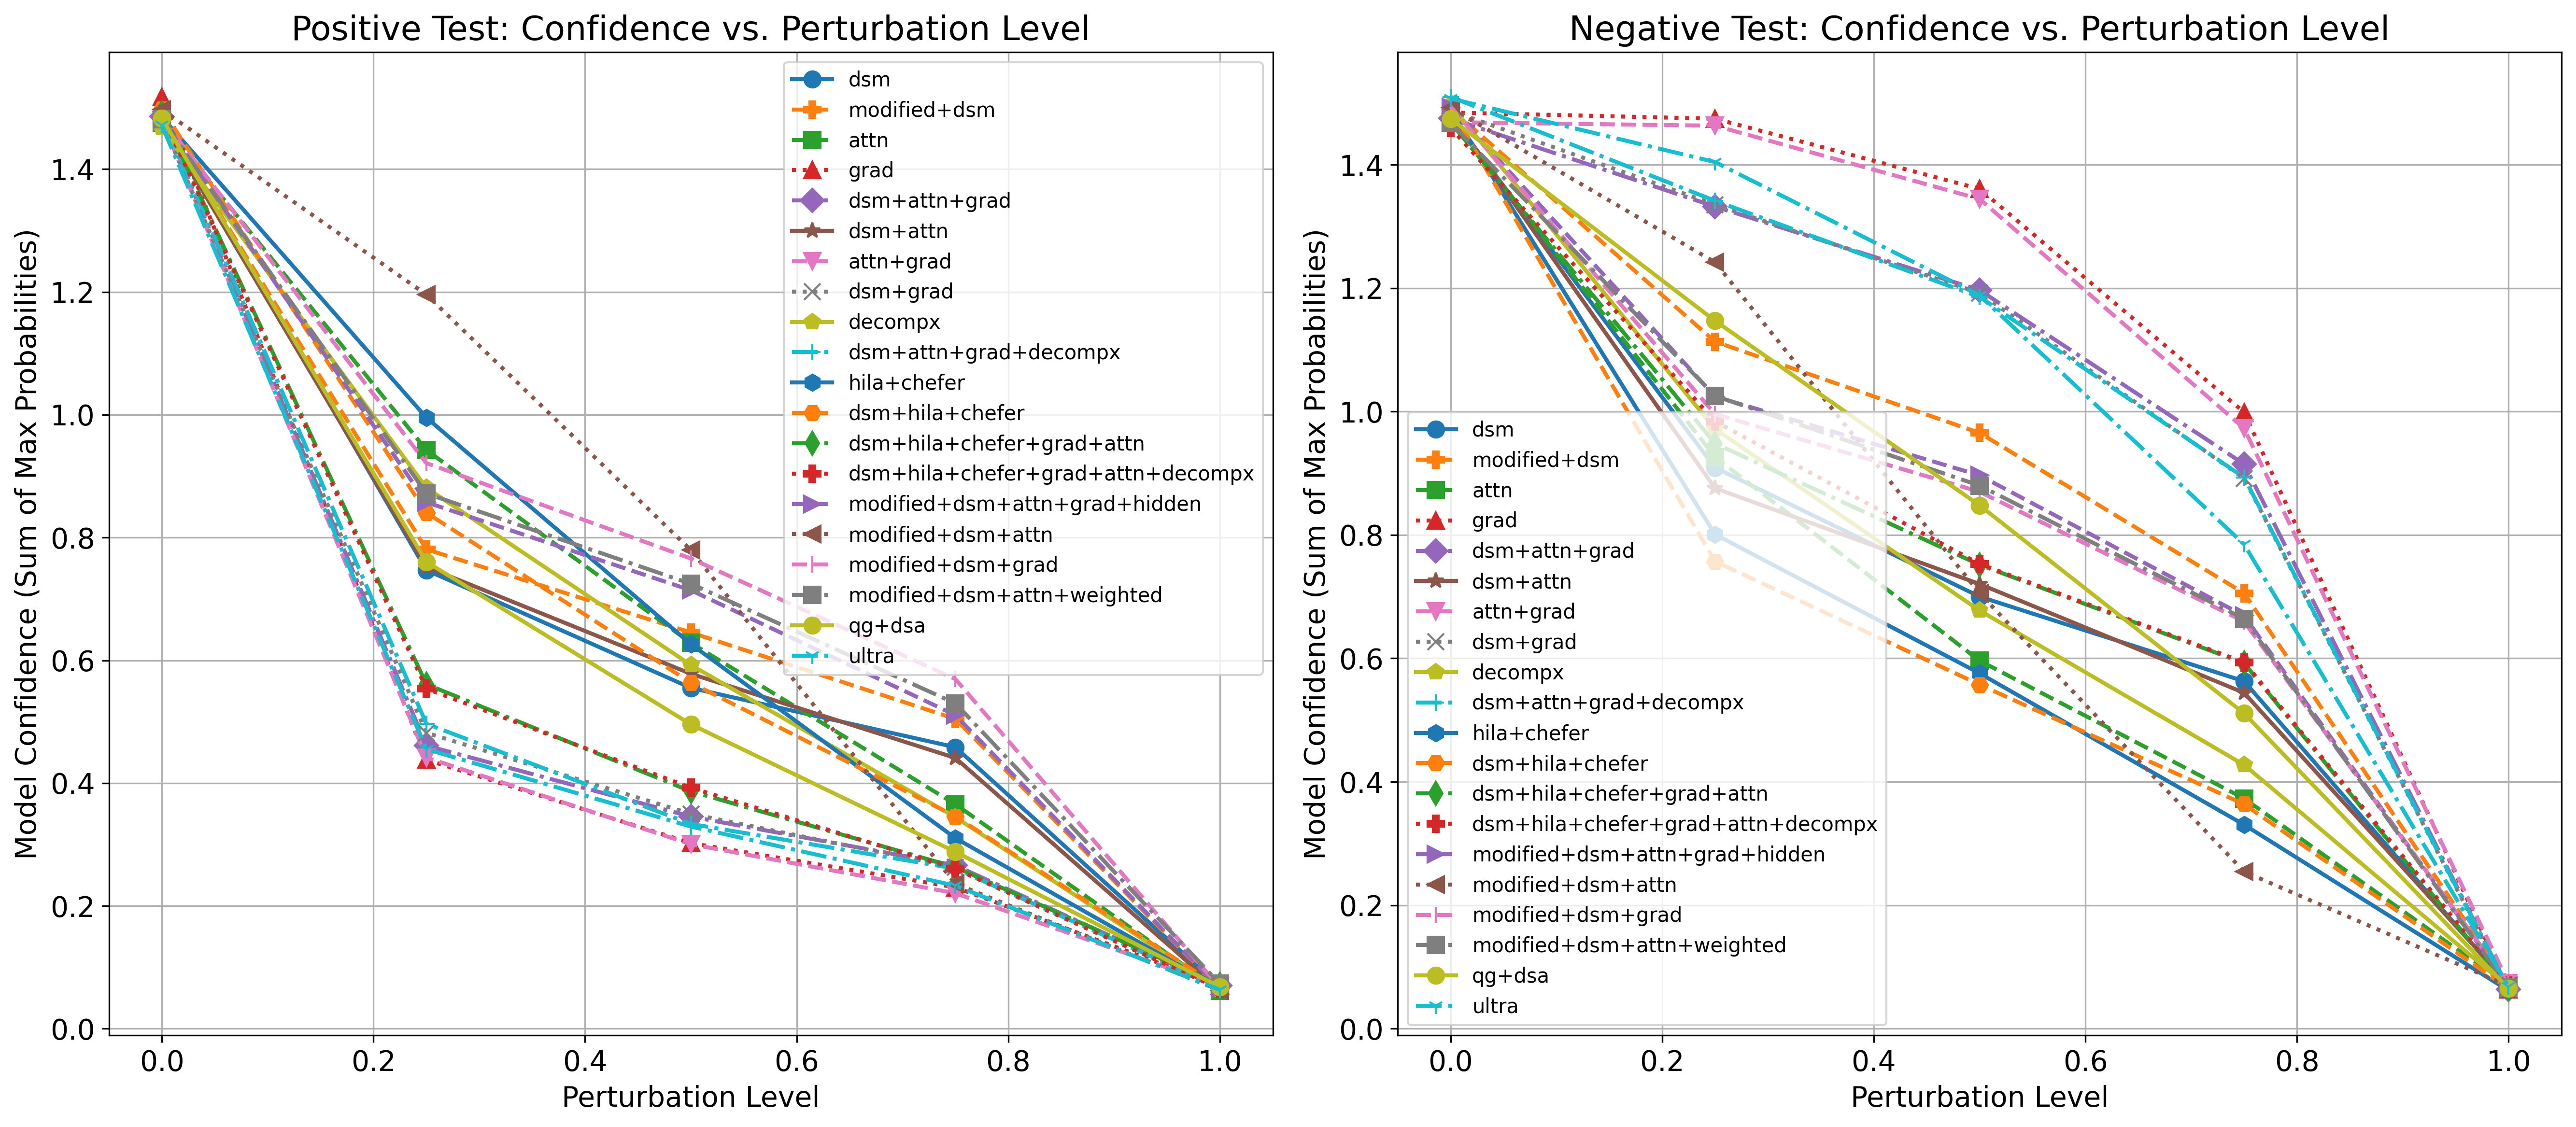

dsm:
  Positive Test AUC: 0.634494, Avg Confidence: [1.486386   0.74698    0.5550461  0.45842913 0.06865961]
  Negative Test AUC: 0.736742, Avg Confidence: [1.4802103  0.9090812  0.7001004  0.5629429  0.06948031]
modified+dsm:
  Positive Test AUC: 0.675878, Avg Confidence: [1.4810671  0.78078926 0.6453189  0.50460273 0.0645366 ]
  Negative Test AUC: 0.891329, Avg Confidence: [1.4912492  1.1132922  0.9654867  0.70563215 0.07056437]
attn:
  Positive Test AUC: 0.676354, Avg Confidence: [1.4758501  0.9425829  0.6283562  0.36557165 0.0619598 ]
  Negative Test AUC: 0.666898, Avg Confidence: [1.4753386  0.9262243  0.5962716  0.37287965 0.06909274]
grad:
  Positive Test AUC: 0.441134, Avg Confidence: [1.5178194  0.4380956  0.30223498 0.23026909 0.07004982]
  Negative Test AUC: 1.152148, Avg Confidence: [1.4846824  1.474726   1.360936   0.9989455  0.06328415]
dsm+attn+grad:
  Positive Test AUC: 0.462597, Avg Confidence: [1.4859658  0.46105614 0.3454529  0.2659301  0.06992953]
  Negative Test AU

In [ ]:
def main():
    for idx, example in enumerate(data):
        if idx == 200:
            break
        print(f"\nSample {idx}")

        (dsm_scores, modified_dsm_scores,modified_dsm_attn_grad_hidden_scores,modified_dsm_attn_scores,modified_dsm_grad_scores,modified_dsm_attn_weighted_scores,qg_dsa_scores, attn_scores, grad_scores, dsm_attn_grad_scores,
         dsm_attn_scores, attn_grad_scores, dsm_grad_scores,
         decompx_scores, dsm_attn_grad_decompx_scores,
         hila_chefer_scores, dsm_hila_chefer_scores,
         dsm_hila_chefer_grad_attn_scores, dsm_hila_chefer_grad_attn_decompx_scores,ultra_scores,
         original_answer, inputs, outputs) = process_example(example, model, tokenizer, use_all_layers=True,idx=idx)

        text_len = len(dsm_scores) - 2
        score_dict = {
            'dsm': dsm_scores,
            'modified_dsm': modified_dsm_scores,
            'attn': attn_scores,
            'grad': grad_scores,
            'dsm_attn_grad': dsm_attn_grad_scores,
            'dsm_attn': dsm_attn_scores,
            'attn_grad': attn_grad_scores,
            'dsm_grad': dsm_grad_scores,
            'decompx': decompx_scores,
            'dsm_attn_grad_decompx': dsm_attn_grad_decompx_scores,
            'hila_chefer': hila_chefer_scores,
            'dsm_hila_chefer': dsm_hila_chefer_scores,
            'dsm_hila_chefer_grad_attn': dsm_hila_chefer_grad_attn_scores,
            'dsm_hila_chefer_grad_attn_decompx': dsm_hila_chefer_grad_attn_decompx_scores,
            'modified_dsm_attn_grad_hidden': modified_dsm_attn_grad_hidden_scores,
            'modified_dsm_attn': modified_dsm_attn_scores,
            'modified_dsm_grad': modified_dsm_grad_scores,
            'modified_dsm_attn_weighted': modified_dsm_attn_weighted_scores,
            'qg_dsa': qg_dsa_scores,
            'ultra': ultra_scores,
        }

        for step_idx, step in enumerate(pert_steps):
            num_to_keep = int((1 - step.item()) * text_len)
            num_to_mask = text_len - num_to_keep

            for score_type, scores in score_dict.items():
                if num_to_keep == text_len:
                    curr_inputs_pos = inputs
                else:
                    _, indices_pos = torch.sort(scores[1:-1], descending=True)
                    indices_pos = indices_pos[:num_to_mask] + 1
                    mask_pos = torch.ones_like(inputs["attention_mask"])
                    mask_pos[:, indices_pos] = 0
                    curr_inputs_pos = {
                        "input_ids": inputs["input_ids"],
                        "attention_mask": mask_pos,
                        "token_type_ids": inputs["token_type_ids"]
                    }

                if num_to_keep == text_len:
                    curr_inputs_neg = inputs
                else:
                    _, indices_neg = torch.sort(scores[1:-1], descending=False)
                    indices_neg = indices_neg[:num_to_mask] + 1
                    mask_neg = torch.ones_like(inputs["attention_mask"])
                    mask_neg[:, indices_neg] = 0
                    curr_inputs_neg = {
                        "input_ids": inputs["input_ids"],
                        "attention_mask": mask_neg,
                        "token_type_ids": inputs["token_type_ids"]
                    }

                _, confidence_pos, _ = get_answer_and_confidence(model, tokenizer, curr_inputs_pos)
                _, confidence_neg, _ = get_answer_and_confidence(model, tokenizer, curr_inputs_neg)

                pert_scores_pos[score_type][step_idx, idx] = confidence_pos
                pert_scores_neg[score_type][step_idx, idx] = confidence_neg

                if idx == 0 and step_idx == 0:
                    print(f"{score_type}: Pos Confidence = {confidence_pos:.4f}, Neg Confidence = {confidence_neg:.4f}")

        print(f"Processed {idx + 1}/{len(data)}")

    # Compute averages
    num_processed = idx + 1
    avg_scores_pos = {key: scores[:, :num_processed].mean(dim=1).cpu().numpy()
                     for key, scores in pert_scores_pos.items()}
    avg_scores_neg = {key: scores[:, :num_processed].mean(dim=1).cpu().numpy()
                     for key, scores in pert_scores_neg.items()}

    # Define distinct line styles and markers for each score type
    styles = {
        'dsm': {'linestyle': '-', 'marker': 'o'},
        'modified_dsm': {'linestyle': '--', 'marker': 'P'},
        'attn': {'linestyle': '--', 'marker': 's'},
        'grad': {'linestyle': ':', 'marker': '^'},
        'dsm_attn_grad': {'linestyle': '-.', 'marker': 'D'},
        'dsm_attn': {'linestyle': '-', 'marker': '*'},
        'attn_grad': {'linestyle': '--', 'marker': 'v'},
        'dsm_grad': {'linestyle': ':', 'marker': 'x'},
        'decompx': {'linestyle': '-', 'marker': 'p'},
        'dsm_attn_grad_decompx': {'linestyle': '-.', 'marker': '+'},
        'hila_chefer': {'linestyle': '-', 'marker': 'h'},
        'dsm_hila_chefer': {'linestyle': '--', 'marker': 'H'},
        'dsm_hila_chefer_grad_attn': {'linestyle': '-.', 'marker': 'd'},
        'dsm_hila_chefer_grad_attn_decompx': {'linestyle': ':', 'marker': 'P'},
        'modified_dsm_attn_grad_hidden': {'linestyle': '--', 'marker': '>'},
        'modified_dsm_attn': {'linestyle': ':', 'marker': '<'},
        'modified_dsm_grad': {'linestyle': '--', 'marker': '|'},
        'modified_dsm_attn_weighted': {'linestyle': '-.', 'marker': 's'},
        'qg_dsa': {'linestyle': '-', 'marker': 'o'},
        'ultra': {'linestyle': '-.', 'marker': '1'}
    }

    plt.rcParams.update({
      "pdf.fonttype": 42,      # Use TrueType fonts
      "ps.fonttype": 42,
      "font.size": 14,
      "figure.dpi": 300,
      "savefig.dpi": 300
    })

    # Create separate plots
    plt.figure(figsize=(18, 8))

    # Positive Test Plot
    plt.subplot(1, 2, 1)
    for key in avg_scores_pos:
        label = key.replace('_', '+')
        plt.plot(pert_steps.cpu().numpy(), avg_scores_pos[key],
                 label=label,
                 linestyle=styles[key]['linestyle'],
                 marker=styles[key]['marker'],
                 linewidth=2, markersize=8)
    plt.title("Positive Test: Confidence vs. Perturbation Level")
    plt.xlabel("Perturbation Level")
    plt.ylabel("Model Confidence (Sum of Max Probabilities)")
    plt.legend(loc='best', fontsize=10)
    plt.grid(True)

    # Negative Test Plot
    plt.subplot(1, 2, 2)
    for key in avg_scores_neg:
        label = key.replace('_', '+')
        plt.plot(pert_steps.cpu().numpy(), avg_scores_neg[key],
                 label=label,
                 linestyle=styles[key]['linestyle'],
                 marker=styles[key]['marker'],
                 linewidth=2, markersize=8)
    plt.title("Negative Test: Confidence vs. Perturbation Level")
    plt.xlabel("Perturbation Level")
    plt.ylabel("Model Confidence (Sum of Max Probabilities)")
    plt.legend(loc='best', fontsize=10)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('perturbation_plots.pdf', format='pdf')
    plt.show()

    # Print AUC scores and average confidence
    for key in avg_scores_pos:
        auc_pos = auc(pert_steps.cpu().numpy(), avg_scores_pos[key])
        auc_neg = auc(pert_steps.cpu().numpy(), avg_scores_neg[key])
        print(f"{key.replace('_', '+')}:")
        print(f"  Positive Test AUC: {auc_pos:.6f}, Avg Confidence: {avg_scores_pos[key]}")
        print(f"  Negative Test AUC: {auc_neg:.6f}, Avg Confidence: {avg_scores_neg[key]}")

# Run the main loop
if __name__ == "__main__":
    main()


# Score Table for 200 sample

| Method | Positive Test AUC | Negative Test AUC |
| --- | --- | --- |
| dsm | 0.726657 | 0.737665 |
| modified+dsm+attn+grad | 0.697154 | 0.991986 |
| modified+dsm+attn+grad+hidden | 0.792352 | 0.898721 |
| modified+dsm+attn | 0.788733 | 0.809801 |
| modified+dsm+grad | 0.764138 | 0.925037 |
| modified+dsm+attn+weighted | 0.764138 | 0.925037 |
| attn | 0.426023 | 0.475286 |
| grad | 0.445438 | 1.248611 |
| dsm+attn+grad | 0.472859 | 1.163188 |
| dsm+attn | 0.726657 | 0.737665 |
| attn+grad | 0.445438 | 1.248611 |
| dsm+grad | 0.472687 | 1.162378 |
| decompx | 0.707491 | 0.800388 |
| dsm+attn+grad+decompx | 0.467516 | 1.157955 |
| hila+chefer | 0.720815 | 0.682438 |
| dsm+hila+chefer | 0.706797 | 0.688118 |
| dsm+hila+chefer+grad+attn | 0.543273 | 0.851134 |
| dsm+hila+chefer+grad+attn+decompx | 0.547559 | 0.852650 |
| Ultra | 0.451328 | 1.034195 |
| QG DSM | 0.648225 | 0.823340 |


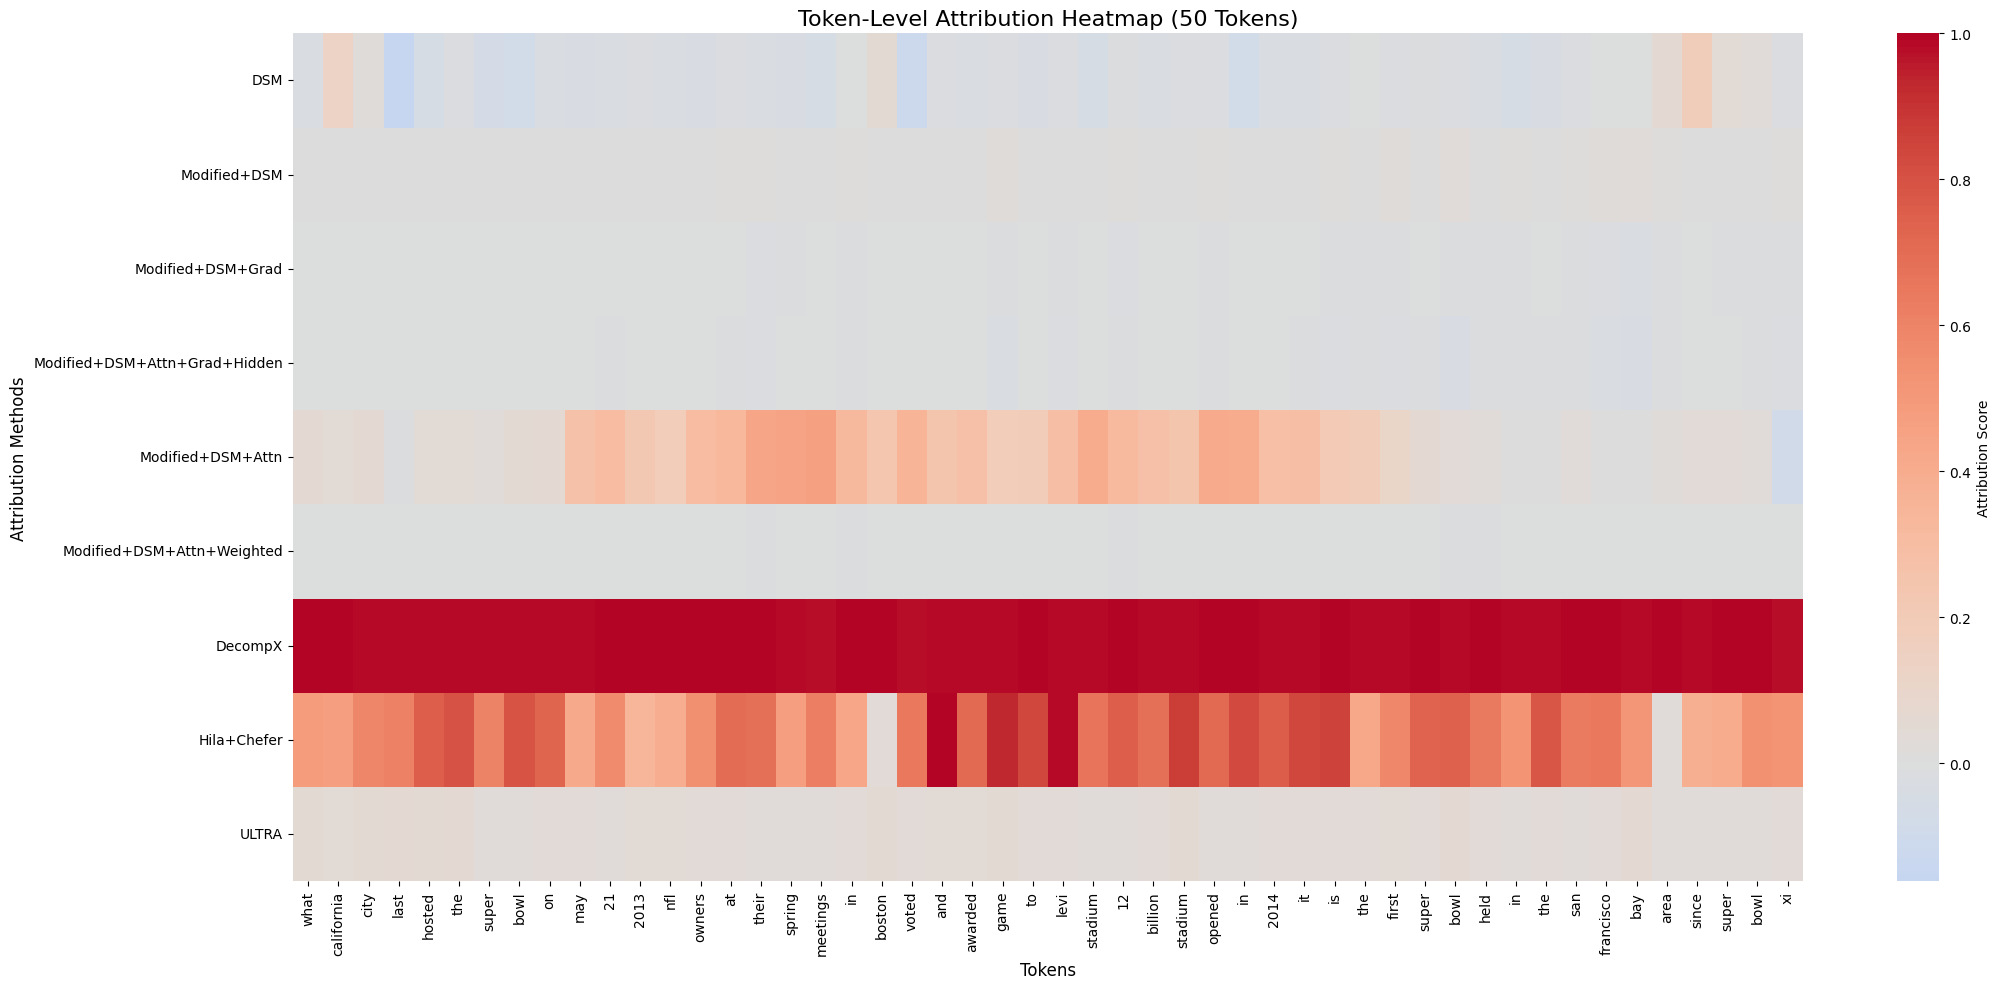

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Simulated data parsing: truncate or extend as needed
# NOTE: In real scenario, parse directly from your actual log or structured output
tokens = [
    "what", "california", "city", "last", "hosted", "the", "super", "bowl",
    "on", "may", "21", "2013", "nfl", "owners", "at", "their", "spring",
    "meetings", "in", "boston", "voted", "and", "awarded", "game", "to", "levi",
    "stadium", "12", "billion", "stadium", "opened", "in", "2014", "it", "is",
    "the", "first", "super", "bowl", "held", "in", "the", "san", "francisco",
    "bay", "area", "since", "super", "bowl", "xi"
]

# Simulated attribution scores per method (first 50 tokens shown)
methods = {
    "DSM": [-0.0215, 0.1271, 0.0223, -0.1615, -0.0451, -0.0199, -0.0632, -0.0754, -0.0287, -0.0301, -0.0238, -0.0160, -0.0272, -0.0351, -0.0197, -0.0209, -0.0331, -0.0438, -0.0071, 0.0551, -0.1185, -0.0145, -0.0298, -0.0159, -0.0318, -0.0141, -0.0473, -0.0098, -0.0212, -0.0185, -0.0176, -0.0821, -0.0285, -0.0259, -0.0118, -0.0056, -0.0139, -0.0111, -0.0131, -0.0255, -0.0444, -0.0344, -0.0172, -0.0019, -0.0018, 0.0635, 0.1770, 0.0428, 0.0255, -0.0170, -0.0388, -0.0344, -0.0243, -0.0120, -0.0070, -0.0100, -0.0063, -0.0113, -0.0264, -0.0063, 0.0723, -0.0108, -0.0325, -0.0230, -0.0310, -0.0101, -0.0214, -0.0069, -0.0073, -0.0057, 0.0047, 0.0905, 1.0000, -0.0005, 0.0042],
    "Modified+DSM": [0.0039, 0.0042, 0.0036, 0.0036, 0.0036, 0.0066, 0.0043, 0.0033, 0.0033, 0.0055, 0.0063, 0.0047, 0.0037, 0.0049, 0.0116, 0.0136, 0.0080, 0.0052, 0.0129, 0.0045, 0.0052, 0.0049, 0.0042, 0.0184, 0.0062, 0.0109, 0.0066, 0.0116, 0.0046, 0.0085, 0.0134, 0.0053, 0.0071, 0.0076, 0.0139, 0.0094, 0.0203, 0.0099, 0.0270, 0.0093, 0.0114, 0.0071, 0.0110, 0.0236, 0.0290, 0.0119, 0.0055, 0.0104, 0.0106, 0.0146, 0.0168, 0.0113, 0.0265, -1.0000, 0.0268, 0.0098, 0.0070, 0.0437, 0.0114, 0.0200, 0.0056, 0.0082, 0.0128, 0.0084, 0.0153, 0.0562, 0.1127, 0.0249, 0.0358, 0.0307, 0.0094, 0.0110, 0.0038, 0.0152, 0.0079],
    "Modified+DSM+Grad": [-0.0049, -0.0050, -0.0046, -0.0047, -0.0048, -0.0061, -0.0066, -0.0049, -0.0047, -0.0056, -0.0069, -0.0058, -0.0049, -0.0053, -0.0072, -0.0133, -0.0082, -0.0065, -0.0108, -0.0052, -0.0062, -0.0057, -0.0054, -0.0093, -0.0058, -0.0091, -0.0068, -0.0138, -0.0059, -0.0063, -0.0081, -0.0061, -0.0057, -0.0070, -0.0110, -0.0083, -0.0099, -0.0071, -0.0113, -0.0093, -0.0086, -0.0069, -0.0083, -0.0175, -0.0243, -0.0077, -0.0059, -0.0075, -0.0083, -0.0089, -0.0115, -0.0071, -0.0086, 1.0000, -0.0360, -0.0099, -0.0057, -0.0243, -0.0077, -0.0084, -0.0056, -0.0076, -0.0103, -0.0075, -0.0069, -0.3242, -0.0199, -0.0244, -0.0175, -0.0232, -0.0120, -0.0075, -0.0048, -0.0059, -0.0072],
    "Modified+DSM+Attn+Grad+Hidden": [-0.0036, -0.0028, -0.0034, -0.0029, -0.0035, -0.0067, -0.0059, -0.0048, -0.0058, -0.0064, -0.0077, -0.0052, -0.0035, -0.0046, -0.0100, -0.0128, -0.0071, -0.0052, -0.0100, -0.0039, -0.0055, -0.0048, -0.0045, -0.0214, -0.0059, -0.0149, -0.0067, -0.0088, -0.0062, -0.0065, -0.0073, -0.0050, -0.0069, -0.0083, -0.0184, -0.0081, -0.0145, -0.0117, -0.0303, -0.0105, -0.0113, -0.0076, -0.0091, -0.0245, -0.0308, -0.0098, -0.0051, -0.0062, -0.0106, -0.0124, -0.0147, -0.0104, -0.0136, -0.0400, -0.0738, -0.0082, -0.0105, -0.0872, -0.0087, -0.0171, -0.0048, -0.0070, -0.0154, -0.0108, -0.0114, 1.0000, -0.0396, -0.0239, -0.0237, -0.0211, -0.0558, -0.0120, -0.0048, -0.0108, -0.0107],
    "Modified+DSM+Attn": [0.0612, 0.0459, 0.0585, -0.0114, 0.0467, 0.0469, 0.0329, 0.0481, 0.0624, 0.2733, 0.3065, 0.2274, 0.1876, 0.3090, 0.3331, 0.4394, 0.4466, 0.4621, 0.3278, 0.2399, 0.3567, 0.2505, 0.2788, 0.1840, 0.1950, 0.2927, 0.4043, 0.3184, 0.2765, 0.2468, 0.4067, 0.4015, 0.2854, 0.2891, 0.2101, 0.1888, 0.1089, 0.0619, 0.0408, 0.0278, 0.0019, 0.0109, 0.0314, 0.0109, 0.0089, 0.0206, 0.0370, 0.0403, 0.0311, -0.0852, -0.1358, -0.1458, -0.2796, -0.3041, -0.1414, -0.1415, -0.0803, -0.1306, -0.1926, -0.2009, -0.2015, -0.3417, -0.4005, -0.4060, -0.7154, -0.8648, -1.0000, -0.8026, -0.5071, -0.5018, -0.3067, -0.2934, -0.2300, -0.2986, -0.2623],
    "Modified+DSM+Attn+Weighted": [-0.0043, -0.0040, -0.0040, -0.0042, -0.0042, -0.0056, -0.0049, -0.0045, -0.0045, -0.0049, -0.0057, -0.0047, -0.0043, -0.0046, -0.0060, -0.0085, -0.0064, -0.0052, -0.0089, -0.0042, -0.0048, -0.0045, -0.0044, -0.0068, -0.0050, -0.0057, -0.0056, -0.0104, -0.0050, -0.0063, -0.0056, -0.0046, -0.0048, -0.0057, -0.0048, -0.0065, -0.0062, -0.0057, -0.0105, -0.0073, -0.0061, -0.0053, -0.0067, -0.0072, -0.0068, -0.0056, -0.0049, -0.0055, -0.0058, -0.0066, -0.0059, -0.0060, -0.0072, -0.5479, -0.0066, -0.0081, -0.0051, -0.0132, -0.0062, -0.0065, -0.0045, -0.0058, -0.0079, -0.0061, -0.0058, 1.0000, -0.0106, -0.0092, -0.0060, -0.0095, -0.0067, -0.0064, -0.0043, -0.0049, -0.0059],
    #"qg_dsa_scores": [-0.0258, -0.0262, -0.0253, -0.0283, -0.0226, -0.0175, -0.0247, -0.0256, -0.0277, -0.0228, -0.0202, -0.0211, -0.0212, -0.0258, -0.0202, -0.0214, -0.0272, -0.0272, -0.0207, -0.0314, -0.0254, -0.0159, -0.0229, -0.0167, -0.0181, -0.0175, -0.0251, -0.0204, -0.0224, -0.0176, -0.0258, -0.0311, -0.0255, -0.0233, -0.0166, -0.0214, -0.0195, -0.0182, -0.0160, -0.0219, -0.0252, -0.0236, -0.0248, -0.0212, -0.0206, -0.0325, -0.0302, -0.0296, -0.0287, -0.0234, -0.0273, -0.0241, -0.0289, -0.0274, -0.0199, -0.0251, -0.0170, -0.0208, -0.0239, -0.0226, -0.0267, -0.0239, -0.0307, -0.0252, -0.0302, -0.0265, -0.0311, -0.0271, -0.0262, -0.0278, -0.0236, -0.0652, -0.1388, -0.0199, -0.0248],
    #"Attn": [0.0131, 0.0130, 0.0131, 0.0130, 0.0130, 0.0130, 0.0129, 0.0130, 0.0130, 0.0130, 0.0128, 0.0129, 0.0130, 0.0130, 0.0128, 0.0131, 0.0131, 0.0131, 0.0128, 0.0131, 0.0130, 0.0129, 0.0128, 0.0129, 0.0130, 0.0129, 0.0130, 0.0130, 0.0130, 0.0131, 0.0131, 0.0127, 0.0131, 0.0130, 0.0131, 0.0132, 0.0130, 0.0131, 0.0132, 0.0131, 0.0128, 0.0129, 0.0131, 0.0130, 0.0131, 0.0131, 0.0129, 0.0129, 0.0131, 0.0130, 0.0131, 0.0128, 0.0129, 0.0130, 0.0129, 0.0130, 0.0129, 0.0131, 0.0128, 0.0129, 0.0130, 0.0131, 0.0130, 0.0130, 0.0129, 0.0130, 0.0129, 0.0130, 0.0129, 0.0131, 0.0132, 0.0131, 0.0131, 0.0129, 0.0130],
    #"Grad": [0.6129, 0.8228, 0.9383, 1.0000, 0.7151, 0.3102, 0.4164, 0.6515, 0.7896, 0.4981, 0.4331, 0.5293, 0.6910, 0.4769, 0.3085, 0.2321, 0.2821, 0.4827, 0.2404, 0.7103, 0.5156, 0.4882, 0.6535, 0.2923, 0.3437, 0.2410, 0.3223, 0.1983, 0.4449, 0.2635, 0.2254, 0.3303, 0.4451, 0.2931, 0.2141, 0.3380, 0.2149, 0.2871, 0.1683, 0.1989, 0.2764, 0.3292, 0.3033, 0.1969, 0.2053, 0.2797, 0.4005, 0.2361, 0.2565, 0.2127, 0.1628, 0.2671, 0.2183, 0.1008, 0.1571, 0.2396, 0.4851, 0.1612, 0.3050, 0.1857, 0.5351, 0.2435, 0.1702, 0.2665, 0.2639, 0.1141, 0.1150, 0.1337, 0.1926, 0.1763, 0.1706, 0.2423, 0.9529, 0.2237, 0.2846],
    #"DSM+Attn+Grad": [0.2056, 0.3260, 0.3307, 0.2910, 0.2326, 0.1032, 0.1250, 0.2009, 0.2633, 0.1637, 0.1436, 0.1789, 0.2302, 0.1549, 0.1026, 0.0764, 0.0893, 0.1540, 0.0836, 0.2640, 0.1405, 0.1655, 0.2166, 0.0984, 0.1107, 0.0815, 0.0983, 0.0685, 0.1485, 0.0878, 0.0751, 0.0894, 0.1462, 0.0954, 0.0732, 0.1174, 0.0728, 0.0983, 0.0572, 0.0636, 0.0835, 0.1048, 0.1018, 0.0706, 0.0735, 0.1203, 0.1989, 0.0987, 0.0999, 0.0710, 0.0469, 0.0837, 0.0704, 0.0346, 0.0554, 0.0824, 0.1671, 0.0554, 0.0992, 0.0653, 0.2101, 0.0836, 0.0514, 0.0873, 0.0837, 0.0398, 0.0363, 0.0474, 0.0673, 0.0624, 0.0639, 0.1166, 0.6583, 0.0802, 0.1024],
    #"DSM+Attn": [-0.0042, 0.0700, 0.0177, -0.0742, -0.0160, -0.0035, -0.0252, -0.0312, -0.0078, -0.0086, -0.0055, -0.0016, -0.0071, -0.0111, -0.0035, -0.0039, -0.0100, -0.0154, 0.0029, 0.0341, -0.0528, -0.0008, -0.0085, -0.0015, -0.0094, -0.0006, -0.0172, 0.0016, -0.0041, -0.0027, -0.0023, -0.0347, -0.0077, -0.0065, 0.0006, 0.0038, -0.0005, 0.0010, 0.0000, -0.0062, -0.0158, -0.0108, -0.0021, 0.0055, 0.0057, 0.0383, 0.0950, 0.0279, 0.0193, -0.0020, -0.0128, -0.0108, -0.0057, 0.0005, 0.0029, 0.0015, 0.0033, 0.0009, -0.0068, 0.0033, 0.0427, 0.0012, -0.0098, -0.0050, -0.0091, 0.0015, -0.0042, 0.0030, 0.0028, 0.0037, 0.0089, 0.0518, 0.5066, 0.0062, 0.0086],
    #"Attn+Grad": [0.3130, 0.4179, 0.4757, 0.5065, 0.3641, 0.1616, 0.2147, 0.3322, 0.4013, 0.2556, 0.2230, 0.2711, 0.3520, 0.2450, 0.1606, 0.1226, 0.1476, 0.2479, 0.1266, 0.3617, 0.2643, 0.2505, 0.3331, 0.1526, 0.1783, 0.1269, 0.1677, 0.1056, 0.2289, 0.1383, 0.1193, 0.1715, 0.2291, 0.1530, 0.1136, 0.1756, 0.1139, 0.1501, 0.0907, 0.1060, 0.1446, 0.1710, 0.1582, 0.1050, 0.1092, 0.1464, 0.2067, 0.1245, 0.1348, 0.1128, 0.0879, 0.1399, 0.1156, 0.0569, 0.0850, 0.1263, 0.2490, 0.0871, 0.1589, 0.0993, 0.2741, 0.1283, 0.0916, 0.1397, 0.1384, 0.0636, 0.0639, 0.0733, 0.1027, 0.0947, 0.0919, 0.1277, 0.4830, 0.1183, 0.1488],
    #"DSM+Grad": [0.2957, 0.4749, 0.4803, 0.4193, 0.3350, 0.1452, 0.1766, 0.2881, 0.3804, 0.2340, 0.2046, 0.2566, 0.3319, 0.2209, 0.1444, 0.1056, 0.1245, 0.2195, 0.1166, 0.3827, 0.1985, 0.2368, 0.3118, 0.1382, 0.1560, 0.1134, 0.1375, 0.0943, 0.2118, 0.1225, 0.1039, 0.1241, 0.2083, 0.1336, 0.1011, 0.1662, 0.1005, 0.1380, 0.0776, 0.0867, 0.1160, 0.1474, 0.1431, 0.0975, 0.1018, 0.1716, 0.2888, 0.1394, 0.1410, 0.0978, 0.0620, 0.1163, 0.0970, 0.0444, 0.0750, 0.1148, 0.2394, 0.0750, 0.1393, 0.0897, 0.3037, 0.1164, 0.0688, 0.1217, 0.1164, 0.0520, 0.0468, 0.0634, 0.0926, 0.0853, 0.0876, 0.1664, 0.9764, 0.1116, 0.1444],
    "DecompX": [0.9947, 0.9951, 0.9876, 0.9874, 0.9873, 0.9846, 0.9884, 0.9897, 0.9905, 0.9902, 0.9967, 0.9913, 0.9969, 0.9932, 0.9932, 0.9944, 0.9881, 0.9751, 0.9922, 0.9996, 0.9809, 0.9890, 0.9901, 0.9867, 0.9945, 0.9882, 0.9862, 0.9935, 0.9907, 0.9887, 0.9953, 0.9962, 0.9904, 0.9907, 0.9924, 0.9893, 0.9903, 0.9944, 0.9861, 0.9949, 0.9893, 0.9897, 0.9923, 0.9919, 0.9859, 0.9985, 0.9908, 0.9958, 0.9972, 0.9774, 0.9909, 0.9891, 0.9915, 0.9922, 0.9924, 0.9915, 0.9897, 0.9900, 0.9956, 0.9934, 0.9939, 0.9795, 0.9894, 0.9882, 0.9952, 0.9915, 0.9915, 0.9906, 0.9969, 1.0000, 0.9926, 0.9970, 0.9892, 0.9919, 0.9896],
    #"DSM+Attn+Grad+DecompX": [0.3998, 0.4895, 0.4903, 0.4597, 0.4176, 0.3220, 0.3386, 0.3947, 0.4411, 0.3678, 0.3547, 0.3794, 0.4184, 0.3620, 0.3237, 0.3047, 0.3126, 0.3568, 0.3096, 0.4445, 0.3477, 0.3689, 0.4067, 0.3190, 0.3299, 0.3070, 0.3185, 0.2988, 0.3568, 0.3117, 0.3040, 0.3143, 0.3550, 0.3177, 0.3019, 0.3337, 0.3011, 0.3209, 0.2886, 0.2954, 0.3085, 0.3243, 0.3229, 0.3000, 0.3006, 0.3387, 0.3953, 0.3219, 0.3231, 0.2965, 0.2820, 0.3086, 0.2996, 0.2735, 0.2888, 0.3085, 0.3703, 0.2882, 0.3218, 0.2964, 0.4036, 0.3063, 0.2850, 0.3112, 0.3102, 0.2771, 0.2745, 0.2826, 0.2988, 0.2959, 0.2953, 0.3357, 0.7388, 0.3070, 0.3228],
    "Hila+Chefer": [0.4850, 0.4758, 0.5876, 0.6117, 0.7532, 0.7970, 0.6059, 0.7947, 0.7318, 0.4218, 0.5670, 0.3494, 0.3928, 0.5497, 0.6985, 0.6836, 0.4744, 0.6167, 0.4352, 0.0349, 0.6526, 1.0000, 0.7126, 0.9342, 0.8337, 0.9851, 0.6671, 0.7518, 0.6828, 0.8690, 0.7184, 0.8304, 0.7601, 0.8351, 0.8516, 0.4276, 0.5818, 0.7351, 0.7449, 0.6457, 0.5244, 0.7836, 0.6337, 0.6484, 0.5160, 0.0269, 0.3893, 0.4013, 0.5386, 0.5321, 0.4354, 0.7247, 0.5340, 0.6185, 0.6131, 0.3356, 0.6144, 0.3147, 0.4509, 0.3974, 0.0899, 0.2101, 0.0682, 0.5520, 0.2783, 0.4779, 0.4222, 0.5592, 0.3941, 0.4790, 0.2007, 0.4620, 0.1730, 0.2354, 0.1977],
    #"DSM+Hila+Chefer": [0.2318, 0.3014, 0.3050, 0.2251, 0.3541, 0.3885, 0.2714, 0.3597, 0.3516, 0.1958, 0.2716, 0.1667, 0.1828, 0.2573, 0.3394, 0.3314, 0.2207, 0.2864, 0.2140, 0.0450, 0.2670, 0.4928, 0.3414, 0.4592, 0.4010, 0.4855, 0.3099, 0.3710, 0.3308, 0.4253, 0.3504, 0.3742, 0.3658, 0.4046, 0.4199, 0.2110, 0.2840, 0.3620, 0.3659, 0.3101, 0.2400, 0.3746, 0.3082, 0.3232, 0.2571, 0.0452, 0.2832, 0.2220, 0.2820, 0.2575, 0.1983, 0.3452, 0.2548, 0.3033, 0.3030, 0.1628, 0.3041, 0.1517, 0.2123, 0.1955, 0.0811, 0.0997, 0.0178, 0.2645, 0.1236, 0.2339, 0.2004, 0.2761, 0.1934, 0.2367, 0.1027, 0.2762, 0.5865, 0.1175, 0.1009],
    #"DSM+Hila+Chefer+Grad+Attn": [0.2724, 0.3597, 0.3903, 0.3658, 0.3591, 0.2751, 0.2430, 0.3460, 0.3764, 0.2257, 0.2473, 0.2189, 0.2674, 0.2511, 0.2500, 0.2270, 0.1841, 0.2672, 0.1703, 0.2033, 0.2657, 0.3716, 0.3373, 0.3059, 0.2897, 0.3062, 0.2388, 0.2383, 0.2799, 0.2818, 0.2348, 0.2728, 0.2974, 0.2788, 0.2667, 0.1933, 0.1990, 0.2561, 0.2283, 0.2081, 0.1923, 0.2728, 0.2332, 0.2141, 0.1832, 0.0958, 0.2449, 0.1733, 0.2084, 0.1852, 0.1431, 0.2425, 0.1852, 0.1801, 0.1940, 0.1445, 0.2765, 0.1194, 0.1856, 0.1474, 0.1776, 0.1140, 0.0547, 0.2021, 0.1310, 0.1487, 0.1322, 0.1747, 0.1481, 0.1657, 0.0973, 0.2020, 0.5347, 0.1179, 0.1249],
    #"DSM+Hila+Chefer+Grad+Attn+DecompX": [0.4168, 0.4868, 0.5098, 0.4901, 0.4847, 0.4170, 0.3921, 0.4747, 0.4993, 0.3786, 0.3972, 0.3734, 0.4133, 0.3995, 0.3986, 0.3805, 0.3449, 0.4088, 0.3347, 0.3626, 0.4087, 0.4951, 0.4678, 0.4420, 0.4306, 0.4426, 0.3883, 0.3894, 0.4220, 0.4232, 0.3869, 0.4175, 0.4360, 0.4212, 0.4119, 0.3525, 0.3572, 0.4037, 0.3799, 0.3654, 0.3517, 0.4162, 0.3850, 0.3697, 0.3437, 0.2763, 0.3941, 0.3378, 0.3662, 0.3436, 0.3127, 0.3919, 0.3465, 0.3425, 0.3537, 0.3139, 0.4192, 0.2935, 0.3476, 0.3166, 0.3408, 0.2871, 0.2416, 0.3593, 0.3038, 0.3173, 0.3040, 0.3379, 0.3178, 0.3325, 0.2763, 0.3610, 0.6256, 0.2927, 0.2978],
    "ULTRA": [0.0545, 0.0445, 0.0555, 0.0649, 0.0536, 0.0623, 0.0328, 0.0335, 0.0406, 0.0371, 0.0320, 0.0450, 0.0460, 0.0390, 0.0379, 0.0313, 0.0264, 0.0297, 0.0403, 0.0473, 0.0379, 0.0466, 0.0465, 0.0518, 0.0366, 0.0416, 0.0260, 0.0308, 0.0401, 0.0482, 0.0272, 0.0303, 0.0374, 0.0394, 0.0393, 0.0342, 0.0452, 0.0392, 0.0565, 0.0353, 0.0286, 0.0337, 0.0290, 0.0415, 0.0594, 0.0328, 0.0288, 0.0285, 0.0276, 0.0359, 0.0234, 0.0253, 0.0215, 0.0215, 0.0339, 0.0287, 0.0558, 0.0383, 0.0316, 0.0328, 0.0359, 0.0402, 0.0253, 0.0274, 0.0222, 0.0206, 0.0193, 0.0221, 0.0279, 0.0238, 0.0374, 0.0316, 0.0396, 0.0364, 0.0388]
}

num_tokens = len(tokens)
data_for_df = {
    method: scores[:num_tokens] for method, scores in methods.items()
}

# 2. Create the DataFrame correctly.
#   - Use the truncated data.
#   - Set the tokens as the index.
#   - Transpose the DataFrame so methods are rows and tokens are columns.
df = pd.DataFrame(data_for_df, index=tokens).T

# Plot the heatmap
plt.figure(figsize=(22, 10))  # Adjusted figure size for better readability
sns.heatmap(
    df,
    cmap="coolwarm",       # Use a diverging colormap
    center=0,              # Center the colormap at zero
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'Attribution Score'} # Add label to the color bar
)

# Add titles and labels for clarity
plt.title(f"Token-Level Attribution Heatmap ({num_tokens} Tokens)", fontsize=16)
plt.xlabel("Tokens", fontsize=12)
plt.ylabel("Attribution Methods", fontsize=12)

# Rotate token labels for better visibility
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Ensure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Extracted from the given token attribution for a sample
tokens = [
    "what", "california", "city", "last", "hosted", "the", "super", "bowl", "on", "may",
    "21", "2013", "nfl", "owners", "at", "their", "spring", "meetings", "in", "boston",
    "voted", "and", "awarded", "the", "game", "to", "levi", "s", "stadium", "the",
    "12", "billion", "stadium", "opened", "in", "2014", "it", "is", "the", "first",
    "super", "bowl", "held", "in", "the", "san", "francisco", "bay", "area", "since",
    "super", "bowl", "xi", "x", "in", "1985", "and", "the", "first", "in", "california",
    "since", "super", "bowl", "xx", "x", "vi", "i", "took", "place", "in", "san",
    "diego", "in", "2003"
]

# Each method's attribution scores for the tokens
attribution_scores = {
    "DSM": [-0.0215, 0.1271, 0.0223, -0.1615, -0.0451, -0.0199, -0.0632, -0.0754, -0.0287, -0.0301, -0.0238, -0.0160, -0.0272, -0.0351, -0.0197, -0.0209, -0.0331, -0.0438, -0.0071, 0.0551, -0.1185, -0.0145, -0.0298, -0.0159, -0.0318, -0.0141, -0.0473, -0.0098, -0.0212, -0.0185, -0.0176, -0.0821, -0.0285, -0.0259, -0.0118, -0.0056, -0.0139, -0.0111, -0.0131, -0.0255, -0.0444, -0.0344, -0.0172, -0.0019, -0.0018, 0.0635, 0.1770, 0.0428, 0.0255, -0.0170, -0.0388, -0.0344, -0.0243, -0.0120, -0.0070, -0.0100, -0.0063, -0.0113, -0.0264, -0.0063, 0.0723, -0.0108, -0.0325, -0.0230, -0.0310, -0.0101, -0.0214, -0.0069, -0.0073, -0.0057, 0.0047, 0.0905, 1.0000, -0.0005, 0.0042],
    "Modified+DSM": [0.0039, 0.0042, 0.0036, 0.0036, 0.0036, 0.0066, 0.0043, 0.0033, 0.0033, 0.0055, 0.0063, 0.0047, 0.0037, 0.0049, 0.0116, 0.0136, 0.0080, 0.0052, 0.0129, 0.0045, 0.0052, 0.0049, 0.0042, 0.0184, 0.0062, 0.0109, 0.0066, 0.0116, 0.0046, 0.0085, 0.0134, 0.0053, 0.0071, 0.0076, 0.0139, 0.0094, 0.0203, 0.0099, 0.0270, 0.0093, 0.0114, 0.0071, 0.0110, 0.0236, 0.0290, 0.0119, 0.0055, 0.0104, 0.0106, 0.0146, 0.0168, 0.0113, 0.0265, -1.0000, 0.0268, 0.0098, 0.0070, 0.0437, 0.0114, 0.0200, 0.0056, 0.0082, 0.0128, 0.0084, 0.0153, 0.0562, 0.1127, 0.0249, 0.0358, 0.0307, 0.0094, 0.0110, 0.0038, 0.0152, 0.0079],
    "Modified+DSM+Grad": [-0.0049, -0.0050, -0.0046, -0.0047, -0.0048, -0.0061, -0.0066, -0.0049, -0.0047, -0.0056, -0.0069, -0.0058, -0.0049, -0.0053, -0.0072, -0.0133, -0.0082, -0.0065, -0.0108, -0.0052, -0.0062, -0.0057, -0.0054, -0.0093, -0.0058, -0.0091, -0.0068, -0.0138, -0.0059, -0.0063, -0.0081, -0.0061, -0.0057, -0.0070, -0.0110, -0.0083, -0.0099, -0.0071, -0.0113, -0.0093, -0.0086, -0.0069, -0.0083, -0.0175, -0.0243, -0.0077, -0.0059, -0.0075, -0.0083, -0.0089, -0.0115, -0.0071, -0.0086, 1.0000, -0.0360, -0.0099, -0.0057, -0.0243, -0.0077, -0.0084, -0.0056, -0.0076, -0.0103, -0.0075, -0.0069, -0.3242, -0.0199, -0.0244, -0.0175, -0.0232, -0.0120, -0.0075, -0.0048, -0.0059, -0.0072],
    "Modified+DSM+Attn+Grad+Hidden": [-0.0036, -0.0028, -0.0034, -0.0029, -0.0035, -0.0067, -0.0059, -0.0048, -0.0058, -0.0064, -0.0077, -0.0052, -0.0035, -0.0046, -0.0100, -0.0128, -0.0071, -0.0052, -0.0100, -0.0039, -0.0055, -0.0048, -0.0045, -0.0214, -0.0059, -0.0149, -0.0067, -0.0088, -0.0062, -0.0065, -0.0073, -0.0050, -0.0069, -0.0083, -0.0184, -0.0081, -0.0145, -0.0117, -0.0303, -0.0105, -0.0113, -0.0076, -0.0091, -0.0245, -0.0308, -0.0098, -0.0051, -0.0062, -0.0106, -0.0124, -0.0147, -0.0104, -0.0136, -0.0400, -0.0738, -0.0082, -0.0105, -0.0872, -0.0087, -0.0171, -0.0048, -0.0070, -0.0154, -0.0108, -0.0114, 1.0000, -0.0396, -0.0239, -0.0237, -0.0211, -0.0558, -0.0120, -0.0048, -0.0108, -0.0107],
    "Modified+DSM+Attn": [0.0612, 0.0459, 0.0585, -0.0114, 0.0467, 0.0469, 0.0329, 0.0481, 0.0624, 0.2733, 0.3065, 0.2274, 0.1876, 0.3090, 0.3331, 0.4394, 0.4466, 0.4621, 0.3278, 0.2399, 0.3567, 0.2505, 0.2788, 0.1840, 0.1950, 0.2927, 0.4043, 0.3184, 0.2765, 0.2468, 0.4067, 0.4015, 0.2854, 0.2891, 0.2101, 0.1888, 0.1089, 0.0619, 0.0408, 0.0278, 0.0019, 0.0109, 0.0314, 0.0109, 0.0089, 0.0206, 0.0370, 0.0403, 0.0311, -0.0852, -0.1358, -0.1458, -0.2796, -0.3041, -0.1414, -0.1415, -0.0803, -0.1306, -0.1926, -0.2009, -0.2015, -0.3417, -0.4005, -0.4060, -0.7154, -0.8648, -1.0000, -0.8026, -0.5071, -0.5018, -0.3067, -0.2934, -0.2300, -0.2986, -0.2623],
    "Modified+DSM+Attn+Weighted": [-0.0043, -0.0040, -0.0040, -0.0042, -0.0042, -0.0056, -0.0049, -0.0045, -0.0045, -0.0049, -0.0057, -0.0047, -0.0043, -0.0046, -0.0060, -0.0085, -0.0064, -0.0052, -0.0089, -0.0042, -0.0048, -0.0045, -0.0044, -0.0068, -0.0050, -0.0057, -0.0056, -0.0104, -0.0050, -0.0063, -0.0056, -0.0046, -0.0048, -0.0057, -0.0048, -0.0065, -0.0062, -0.0057, -0.0105, -0.0073, -0.0061, -0.0053, -0.0067, -0.0072, -0.0068, -0.0056, -0.0049, -0.0055, -0.0058, -0.0066, -0.0059, -0.0060, -0.0072, -0.5479, -0.0066, -0.0081, -0.0051, -0.0132, -0.0062, -0.0065, -0.0045, -0.0058, -0.0079, -0.0061, -0.0058, 1.0000, -0.0106, -0.0092, -0.0060, -0.0095, -0.0067, -0.0064, -0.0043, -0.0049, -0.0059],
    "qg_dsa_scores": [-0.0258, -0.0262, -0.0253, -0.0283, -0.0226, -0.0175, -0.0247, -0.0256, -0.0277, -0.0228, -0.0202, -0.0211, -0.0212, -0.0258, -0.0202, -0.0214, -0.0272, -0.0272, -0.0207, -0.0314, -0.0254, -0.0159, -0.0229, -0.0167, -0.0181, -0.0175, -0.0251, -0.0204, -0.0224, -0.0176, -0.0258, -0.0311, -0.0255, -0.0233, -0.0166, -0.0214, -0.0195, -0.0182, -0.0160, -0.0219, -0.0252, -0.0236, -0.0248, -0.0212, -0.0206, -0.0325, -0.0302, -0.0296, -0.0287, -0.0234, -0.0273, -0.0241, -0.0289, -0.0274, -0.0199, -0.0251, -0.0170, -0.0208, -0.0239, -0.0226, -0.0267, -0.0239, -0.0307, -0.0252, -0.0302, -0.0265, -0.0311, -0.0271, -0.0262, -0.0278, -0.0236, -0.0652, -0.1388, -0.0199, -0.0248],
    "Attn": [0.0131, 0.0130, 0.0131, 0.0130, 0.0130, 0.0130, 0.0129, 0.0130, 0.0130, 0.0130, 0.0128, 0.0129, 0.0130, 0.0130, 0.0128, 0.0131, 0.0131, 0.0131, 0.0128, 0.0131, 0.0130, 0.0129, 0.0128, 0.0129, 0.0130, 0.0129, 0.0130, 0.0130, 0.0130, 0.0131, 0.0131, 0.0127, 0.0131, 0.0130, 0.0131, 0.0132, 0.0130, 0.0131, 0.0132, 0.0131, 0.0128, 0.0129, 0.0131, 0.0130, 0.0131, 0.0131, 0.0129, 0.0129, 0.0131, 0.0130, 0.0131, 0.0128, 0.0129, 0.0130, 0.0129, 0.0130, 0.0129, 0.0131, 0.0128, 0.0129, 0.0130, 0.0131, 0.0130, 0.0130, 0.0129, 0.0130, 0.0129, 0.0130, 0.0129, 0.0131, 0.0132, 0.0131, 0.0131, 0.0129, 0.0130],
    "Grad": [0.6129, 0.8228, 0.9383, 1.0000, 0.7151, 0.3102, 0.4164, 0.6515, 0.7896, 0.4981, 0.4331, 0.5293, 0.6910, 0.4769, 0.3085, 0.2321, 0.2821, 0.4827, 0.2404, 0.7103, 0.5156, 0.4882, 0.6535, 0.2923, 0.3437, 0.2410, 0.3223, 0.1983, 0.4449, 0.2635, 0.2254, 0.3303, 0.4451, 0.2931, 0.2141, 0.3380, 0.2149, 0.2871, 0.1683, 0.1989, 0.2764, 0.3292, 0.3033, 0.1969, 0.2053, 0.2797, 0.4005, 0.2361, 0.2565, 0.2127, 0.1628, 0.2671, 0.2183, 0.1008, 0.1571, 0.2396, 0.4851, 0.1612, 0.3050, 0.1857, 0.5351, 0.2435, 0.1702, 0.2665, 0.2639, 0.1141, 0.1150, 0.1337, 0.1926, 0.1763, 0.1706, 0.2423, 0.9529, 0.2237, 0.2846],
    "DSM+Attn+Grad": [0.2056, 0.3260, 0.3307, 0.2910, 0.2326, 0.1032, 0.1250, 0.2009, 0.2633, 0.1637, 0.1436, 0.1789, 0.2302, 0.1549, 0.1026, 0.0764, 0.0893, 0.1540, 0.0836, 0.2640, 0.1405, 0.1655, 0.2166, 0.0984, 0.1107, 0.0815, 0.0983, 0.0685, 0.1485, 0.0878, 0.0751, 0.0894, 0.1462, 0.0954, 0.0732, 0.1174, 0.0728, 0.0983, 0.0572, 0.0636, 0.0835, 0.1048, 0.1018, 0.0706, 0.0735, 0.1203, 0.1989, 0.0987, 0.0999, 0.0710, 0.0469, 0.0837, 0.0704, 0.0346, 0.0554, 0.0824, 0.1671, 0.0554, 0.0992, 0.0653, 0.2101, 0.0836, 0.0514, 0.0873, 0.0837, 0.0398, 0.0363, 0.0474, 0.0673, 0.0624, 0.0639, 0.1166, 0.6583, 0.0802, 0.1024],
    "DSM+Attn": [-0.0042, 0.0700, 0.0177, -0.0742, -0.0160, -0.0035, -0.0252, -0.0312, -0.0078, -0.0086, -0.0055, -0.0016, -0.0071, -0.0111, -0.0035, -0.0039, -0.0100, -0.0154, 0.0029, 0.0341, -0.0528, -0.0008, -0.0085, -0.0015, -0.0094, -0.0006, -0.0172, 0.0016, -0.0041, -0.0027, -0.0023, -0.0347, -0.0077, -0.0065, 0.0006, 0.0038, -0.0005, 0.0010, 0.0000, -0.0062, -0.0158, -0.0108, -0.0021, 0.0055, 0.0057, 0.0383, 0.0950, 0.0279, 0.0193, -0.0020, -0.0128, -0.0108, -0.0057, 0.0005, 0.0029, 0.0015, 0.0033, 0.0009, -0.0068, 0.0033, 0.0427, 0.0012, -0.0098, -0.0050, -0.0091, 0.0015, -0.0042, 0.0030, 0.0028, 0.0037, 0.0089, 0.0518, 0.5066, 0.0062, 0.0086],
    "Attn+Grad": [0.3130, 0.4179, 0.4757, 0.5065, 0.3641, 0.1616, 0.2147, 0.3322, 0.4013, 0.2556, 0.2230, 0.2711, 0.3520, 0.2450, 0.1606, 0.1226, 0.1476, 0.2479, 0.1266, 0.3617, 0.2643, 0.2505, 0.3331, 0.1526, 0.1783, 0.1269, 0.1677, 0.1056, 0.2289, 0.1383, 0.1193, 0.1715, 0.2291, 0.1530, 0.1136, 0.1756, 0.1139, 0.1501, 0.0907, 0.1060, 0.1446, 0.1710, 0.1582, 0.1050, 0.1092, 0.1464, 0.2067, 0.1245, 0.1348, 0.1128, 0.0879, 0.1399, 0.1156, 0.0569, 0.0850, 0.1263, 0.2490, 0.0871, 0.1589, 0.0993, 0.2741, 0.1283, 0.0916, 0.1397, 0.1384, 0.0636, 0.0639, 0.0733, 0.1027, 0.0947, 0.0919, 0.1277, 0.4830, 0.1183, 0.1488],
    "DSM+Grad": [0.2957, 0.4749, 0.4803, 0.4193, 0.3350, 0.1452, 0.1766, 0.2881, 0.3804, 0.2340, 0.2046, 0.2566, 0.3319, 0.2209, 0.1444, 0.1056, 0.1245, 0.2195, 0.1166, 0.3827, 0.1985, 0.2368, 0.3118, 0.1382, 0.1560, 0.1134, 0.1375, 0.0943, 0.2118, 0.1225, 0.1039, 0.1241, 0.2083, 0.1336, 0.1011, 0.1662, 0.1005, 0.1380, 0.0776, 0.0867, 0.1160, 0.1474, 0.1431, 0.0975, 0.1018, 0.1716, 0.2888, 0.1394, 0.1410, 0.0978, 0.0620, 0.1163, 0.0970, 0.0444, 0.0750, 0.1148, 0.2394, 0.0750, 0.1393, 0.0897, 0.3037, 0.1164, 0.0688, 0.1217, 0.1164, 0.0520, 0.0468, 0.0634, 0.0926, 0.0853, 0.0876, 0.1664, 0.9764, 0.1116, 0.1444],
    "DecompX": [0.9947, 0.9951, 0.9876, 0.9874, 0.9873, 0.9846, 0.9884, 0.9897, 0.9905, 0.9902, 0.9967, 0.9913, 0.9969, 0.9932, 0.9932, 0.9944, 0.9881, 0.9751, 0.9922, 0.9996, 0.9809, 0.9890, 0.9901, 0.9867, 0.9945, 0.9882, 0.9862, 0.9935, 0.9907, 0.9887, 0.9953, 0.9962, 0.9904, 0.9907, 0.9924, 0.9893, 0.9903, 0.9944, 0.9861, 0.9949, 0.9893, 0.9897, 0.9923, 0.9919, 0.9859, 0.9985, 0.9908, 0.9958, 0.9972, 0.9774, 0.9909, 0.9891, 0.9915, 0.9922, 0.9924, 0.9915, 0.9897, 0.9900, 0.9956, 0.9934, 0.9939, 0.9795, 0.9894, 0.9882, 0.9952, 0.9915, 0.9915, 0.9906, 0.9969, 1.0000, 0.9926, 0.9970, 0.9892, 0.9919, 0.9896],
    "DSM+Attn+Grad+DecompX": [0.3998, 0.4895, 0.4903, 0.4597, 0.4176, 0.3220, 0.3386, 0.3947, 0.4411, 0.3678, 0.3547, 0.3794, 0.4184, 0.3620, 0.3237, 0.3047, 0.3126, 0.3568, 0.3096, 0.4445, 0.3477, 0.3689, 0.4067, 0.3190, 0.3299, 0.3070, 0.3185, 0.2988, 0.3568, 0.3117, 0.3040, 0.3143, 0.3550, 0.3177, 0.3019, 0.3337, 0.3011, 0.3209, 0.2886, 0.2954, 0.3085, 0.3243, 0.3229, 0.3000, 0.3006, 0.3387, 0.3953, 0.3219, 0.3231, 0.2965, 0.2820, 0.3086, 0.2996, 0.2735, 0.2888, 0.3085, 0.3703, 0.2882, 0.3218, 0.2964, 0.4036, 0.3063, 0.2850, 0.3112, 0.3102, 0.2771, 0.2745, 0.2826, 0.2988, 0.2959, 0.2953, 0.3357, 0.7388, 0.3070, 0.3228],
    "Hila+Chefer": [0.4850, 0.4758, 0.5876, 0.6117, 0.7532, 0.7970, 0.6059, 0.7947, 0.7318, 0.4218, 0.5670, 0.3494, 0.3928, 0.5497, 0.6985, 0.6836, 0.4744, 0.6167, 0.4352, 0.0349, 0.6526, 1.0000, 0.7126, 0.9342, 0.8337, 0.9851, 0.6671, 0.7518, 0.6828, 0.8690, 0.7184, 0.8304, 0.7601, 0.8351, 0.8516, 0.4276, 0.5818, 0.7351, 0.7449, 0.6457, 0.5244, 0.7836, 0.6337, 0.6484, 0.5160, 0.0269, 0.3893, 0.4013, 0.5386, 0.5321, 0.4354, 0.7247, 0.5340, 0.6185, 0.6131, 0.3356, 0.6144, 0.3147, 0.4509, 0.3974, 0.0899, 0.2101, 0.0682, 0.5520, 0.2783, 0.4779, 0.4222, 0.5592, 0.3941, 0.4790, 0.2007, 0.4620, 0.1730, 0.2354, 0.1977],
    "DSM+Hila+Chefer": [0.2318, 0.3014, 0.3050, 0.2251, 0.3541, 0.3885, 0.2714, 0.3597, 0.3516, 0.1958, 0.2716, 0.1667, 0.1828, 0.2573, 0.3394, 0.3314, 0.2207, 0.2864, 0.2140, 0.0450, 0.2670, 0.4928, 0.3414, 0.4592, 0.4010, 0.4855, 0.3099, 0.3710, 0.3308, 0.4253, 0.3504, 0.3742, 0.3658, 0.4046, 0.4199, 0.2110, 0.2840, 0.3620, 0.3659, 0.3101, 0.2400, 0.3746, 0.3082, 0.3232, 0.2571, 0.0452, 0.2832, 0.2220, 0.2820, 0.2575, 0.1983, 0.3452, 0.2548, 0.3033, 0.3030, 0.1628, 0.3041, 0.1517, 0.2123, 0.1955, 0.0811, 0.0997, 0.0178, 0.2645, 0.1236, 0.2339, 0.2004, 0.2761, 0.1934, 0.2367, 0.1027, 0.2762, 0.5865, 0.1175, 0.1009],
    "DSM+Hila+Chefer+Grad+Attn": [0.2724, 0.3597, 0.3903, 0.3658, 0.3591, 0.2751, 0.2430, 0.3460, 0.3764, 0.2257, 0.2473, 0.2189, 0.2674, 0.2511, 0.2500, 0.2270, 0.1841, 0.2672, 0.1703, 0.2033, 0.2657, 0.3716, 0.3373, 0.3059, 0.2897, 0.3062, 0.2388, 0.2383, 0.2799, 0.2818, 0.2348, 0.2728, 0.2974, 0.2788, 0.2667, 0.1933, 0.1990, 0.2561, 0.2283, 0.2081, 0.1923, 0.2728, 0.2332, 0.2141, 0.1832, 0.0958, 0.2449, 0.1733, 0.2084, 0.1852, 0.1431, 0.2425, 0.1852, 0.1801, 0.1940, 0.1445, 0.2765, 0.1194, 0.1856, 0.1474, 0.1776, 0.1140, 0.0547, 0.2021, 0.1310, 0.1487, 0.1322, 0.1747, 0.1481, 0.1657, 0.0973, 0.2020, 0.5347, 0.1179, 0.1249],
    "DSM+Hila+Chefer+Grad+Attn+DecompX": [0.4168, 0.4868, 0.5098, 0.4901, 0.4847, 0.4170, 0.3921, 0.4747, 0.4993, 0.3786, 0.3972, 0.3734, 0.4133, 0.3995, 0.3986, 0.3805, 0.3449, 0.4088, 0.3347, 0.3626, 0.4087, 0.4951, 0.4678, 0.4420, 0.4306, 0.4426, 0.3883, 0.3894, 0.4220, 0.4232, 0.3869, 0.4175, 0.4360, 0.4212, 0.4119, 0.3525, 0.3572, 0.4037, 0.3799, 0.3654, 0.3517, 0.4162, 0.3850, 0.3697, 0.3437, 0.2763, 0.3941, 0.3378, 0.3662, 0.3436, 0.3127, 0.3919, 0.3465, 0.3425, 0.3537, 0.3139, 0.4192, 0.2935, 0.3476, 0.3166, 0.3408, 0.2871, 0.2416, 0.3593, 0.3038, 0.3173, 0.3040, 0.3379, 0.3178, 0.3325, 0.2763, 0.3610, 0.6256, 0.2927, 0.2978],
    "ULTRA": [0.0545, 0.0445, 0.0555, 0.0649, 0.0536, 0.0623, 0.0328, 0.0335, 0.0406, 0.0371, 0.0320, 0.0450, 0.0460, 0.0390, 0.0379, 0.0313, 0.0264, 0.0297, 0.0403, 0.0473, 0.0379, 0.0466, 0.0465, 0.0518, 0.0366, 0.0416, 0.0260, 0.0308, 0.0401, 0.0482, 0.0272, 0.0303, 0.0374, 0.0394, 0.0393, 0.0342, 0.0452, 0.0392, 0.0565, 0.0353, 0.0286, 0.0337, 0.0290, 0.0415, 0.0594, 0.0328, 0.0288, 0.0285, 0.0276, 0.0359, 0.0234, 0.0253, 0.0215, 0.0215, 0.0339, 0.0287, 0.0558, 0.0383, 0.0316, 0.0328, 0.0359, 0.0402, 0.0253, 0.0274, 0.0222, 0.0206, 0.0193, 0.0221, 0.0279, 0.0238, 0.0374, 0.0316, 0.0396, 0.0364, 0.0388]
}

# Create a directory to save the heatmaps if it doesn't exist
output_dir = "heatmaps"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# --- Loop to generate and save individual heatmaps ---
for method, scores in attribution_scores.items():
    # Create a new figure for each heatmap
    fig, ax = plt.subplots(figsize=(25, 4)) # Wide figure to fit all tokens

    # Reshape scores to be a 2D array for the heatmap function
    scores_2d = np.array([scores])

    # Create the heatmap
    sns.heatmap(scores_2d, annot=False, cmap="coolwarm", cbar=True,
                xticklabels=tokens, yticklabels=False, ax=ax, vmin=-1, vmax=1)

    # Customize the plot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=10)
    ax.set_title(f"Token Attribution Heatmap: {method}", fontsize=16, fontweight='bold', pad=20)

    # Create a clean filename (replace '+' with '_' for compatibility)
    clean_method_name = method.replace('+', '_')
    filename = f"heatmap_{clean_method_name}.png"
    filepath = os.path.join(output_dir, filename)

    # Save the figure to a file
    # bbox_inches='tight' helps to fit the plot neatly into the file without extra whitespace
    plt.savefig(filepath, bbox_inches='tight')

    # Close the figure to free up memory and prevent it from being displayed inline
    plt.close(fig)

print(f"All {len(attribution_scores)} heatmaps have been saved to the '{output_dir}' directory.")

All 20 heatmaps have been saved to the 'heatmaps' directory.
